In [ ]:
!pip install networkx
!pip install eli5

In [69]:
import itertools
import math
import eli5

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc 
from sklearn.metrics import roc_auc_score

from sklearn.base import ClassifierMixin
from eli5.sklearn import PermutationImportance

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

%matplotlib inline

### Make the plots look nicer

In [70]:
# Some code to make the plots look nicer
plt.rcParams['figure.dpi'] = 150
sns.set_theme(font='Georgia', style="whitegrid", palette="pastel")
sns.set_context(
    "notebook", 
    rc={
        "font.size":      16,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "axes.labelpad":  15,
        "axes.titlepad":  15,
        # grid
        "grid.linewidth": 0.5,
        "grid.linestyle": ":",
    })

CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'

color_list = [CB91_Blue, CB91_Amber, CB91_Pink, CB91_Green, CB91_Purple, CB91_Violet]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

# The Naive Model

Our naive model predicts the winner of the world cup in addition to the 2nd, 3rd and 4th place teams. The model simulates the tournament by selecting the winner of each match based on the following rules: For each team, we calculate the win probability as the number of wins divided by the number of matches in which the team participated in the list of all matches in the world cup history. The team with the higher win probability wins the match. If the win probabilities are equal, then the winner is selected randomly. 

In the group stage, we have 8 groups (A, B, ..., H) of 4 teams each. In each group, 6 matches take place, and the two teams with the highest number of points are selected to advance to the next round. The points are calculated as follows: 3 points for a win, 1 point for a draw and 0 points for a loss. Hence, 16 teams advance to the next round, with 2 from each group. If there is a draw between points, then the tie is ideally broken by the following rules: 1) Goal difference, 2) Goals scored, 3) Fair play points, 4) Fair play goal difference, 5) Fair play goals scored, 6) Drawing of lots. However, our naive model does not take into account any of these rules, and simply breaks ties randomly.

In the next round, the 16 teams are divided into 8 matches with a predetermined pairing (the winner from group A plays the winner from group B, and so on). The winner of each match advances to the next round (there are no ties allowed, and hence our naive model breaks the ties randomly). The game goes on till the final match, where we find winner of the world cup. The two runner ups in the semi finals then play the third place match to decide the third place and fourth place teams.

This model is non-parametric, and hence does not require any training. However, it is a good starting point that uses the historical data to predict the winner of the world cup. The model we intend to build, however, will be parametric. The winner of the world cup is Brazil! Second, third, and fourth place is Portugal, Argentina, and Denmark, respectively. Below you can see the visualized tournament results.


In [71]:
# getting the dataframes of the matches of the 2022 world cup
df_groups = pd.read_csv('data/group_stage_22.csv')
df_matches = pd.read_csv('data/Matches/WorldCupMatches.csv') 

# standardize the country names
for df in [df_groups, df_matches]:
    df.replace(['Germany FR', 'German DR'], 'Germany', inplace=True)
    df.replace(['IR Iran'], 'Iran', inplace=True)
    df.replace(['USA'], 'United States', inplace=True)
    df.replace(['Korea Republic'], 'South Korea', inplace=True)

print('\ndf_groups has {} rows and {} columns'.format(df_groups.shape[0], df_groups.shape[1]))
display(df_groups.head())
print('\ndf_matches has {} rows and {} columns'.format(df_matches.shape[0], df_matches.shape[1]))
display(df_matches.head())


df_groups has 48 rows and 3 columns


,Home Team,Away Team,Group
0,Qatar,Ecuador,a
1,Senegal,Netherlands,a
2,England,Iran,b
3,United States,Wales,b
4,France,Australia,d



df_matches has 4572 rows and 20 columns


,Year,Datetime,Stage,Stadium,City,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Win conditions,Attendance,Half-time Home Goals,Half-time Away Goals,Referee,Assistant 1,Assistant 2,RoundID,MatchID,Home Team Initials,Away Team Initials
0,1930.0,13 Jul 1930 - 15:00,Group 1,Pocitos,Montevideo,France,4.0,1.0,Mexico,,4444.0,3.0,0.0,LOMBARDI Domingo (URU),CRISTOPHE Henry (BEL),REGO Gilberto (BRA),201.0,1096.0,FRA,MEX
1,1930.0,13 Jul 1930 - 15:00,Group 4,Parque Central,Montevideo,United States,3.0,0.0,Belgium,,18346.0,2.0,0.0,MACIAS Jose (ARG),MATEUCCI Francisco (URU),WARNKEN Alberto (CHI),201.0,1090.0,United States,BEL
2,1930.0,14 Jul 1930 - 12:45,Group 2,Parque Central,Montevideo,Yugoslavia,2.0,1.0,Brazil,,24059.0,2.0,0.0,TEJADA Anibal (URU),VALLARINO Ricardo (URU),BALWAY Thomas (FRA),201.0,1093.0,YUG,BRA
3,1930.0,14 Jul 1930 - 14:50,Group 3,Pocitos,Montevideo,Romania,3.0,1.0,Peru,,2549.0,1.0,0.0,WARNKEN Alberto (CHI),LANGENUS Jean (BEL),MATEUCCI Francisco (URU),201.0,1098.0,ROU,PER
4,1930.0,15 Jul 1930 - 16:00,Group 1,Parque Central,Montevideo,Argentina,1.0,0.0,France,,23409.0,0.0,0.0,REGO Gilberto (BRA),SAUCEDO Ulises (BOL),RADULESCU Constantin (ROU),201.0,1085.0,ARG,FRA


In [72]:
# For every country in df_groups, get the ration of matches won to total matches played in df_matches
def get_win_ratio(country, df_matches):
    # get all matches where the country is the home team
    home_matches = df_matches[df_matches['Home Team Name'] == country]
    # get all matches where the country is the away team
    away_matches = df_matches[df_matches['Away Team Name'] == country]
    # get the total number of matches played by the country
    total_matches = len(home_matches) + len(away_matches)
    # get the total number of matches won by the country
    total_wins = len(home_matches[home_matches['Home Team Goals'] > home_matches['Away Team Goals']]) + len(away_matches[away_matches['Away Team Goals'] > away_matches['Home Team Goals']])
    # return the ratio of wins to total matches played

    return total_wins / total_matches if total_matches > 0 else 0

# Run the tournament's matches starting with the group stage
# For each group, the winner of each match gets 3 points, the loser gets 0 points
# A draw gets 1 point for each team
# The top 2 teams in each group advance to the round of 16
winners_group_stage = {}
for group in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']:
    
    # df_groups has columns Home Team, Away Team, Group
    group_df = df_groups[df_groups['Group'] == group]
    home_teams_df = group_df['Home Team']
    away_teams_df = group_df['Away Team']
    
    # get a set of all the teams in the group
    group_teams_names = set(home_teams_df.values) | set(away_teams_df.values)
    group_win_ratios = {team : get_win_ratio(team, df_matches) for team in group_teams_names}
    home_team_win_ratio = home_teams_df.map(group_win_ratios)
    away_team_win_ratio = away_teams_df.map(group_win_ratios)
    
    # dataframes for winner teams and draw teams
    winners = pd.concat([home_teams_df[home_team_win_ratio > away_team_win_ratio], away_teams_df[home_team_win_ratio < away_team_win_ratio]])
    draws = pd.concat([home_teams_df[home_team_win_ratio == away_team_win_ratio], away_teams_df[home_team_win_ratio == away_team_win_ratio]])
    
    # calculate the points for each team
    points = {team : 0 for team in group_teams_names}
    # for winner teams, add 3 points
    for winner in winners: points[winner] += 3
    # for draw teams, add 1 point
    for draw in draws: points[draw] += 1
    
    # get the top 2 teams in the group
    group_winners = sorted(points, key=points.get, reverse=True)[:2]
    winners_group_stage[group] = group_winners

In [73]:
winners_group_stage

{'a': ['Netherlands', 'Ecuador'],
 'b': ['England', 'United States'],
 'c': ['Argentina', 'Poland'],
 'd': ['Denmark', 'France'],
 'e': ['Germany', 'Spain'],
 'f': ['Croatia', 'Belgium'],
 'g': ['Brazil', 'Serbia'],
 'h': ['Portugal', 'Uruguay']}

In [74]:
# now we have the winners of the group stage
# for round of 16, we have 8 matches
# the top performer from each group plays the second best performer from the other group
# There has to be a winner, which advances to the quarter finals
winners_round_of_16 = {}
for group1, group2 in [('a', 'b'), ('c', 'd'), ('e', 'f'), ('g', 'h')]:
    # get the top 2 teams from each group
    group1_teams = winners_group_stage[group1]
    group2_teams = winners_group_stage[group2]
    # get the win ratios for each team
    group1_win_ratios = {team : get_win_ratio(team, df_matches) for team in group1_teams}
    group2_win_ratios = {team : get_win_ratio(team, df_matches) for team in group2_teams}
    # the top player from group1 plays the second best player from group2
    # the top player from group2 plays the second best player from group1
    winner_match_1 = group1_teams[0] if group1_win_ratios[group1_teams[0]] > group2_win_ratios[group2_teams[1]] else group2_teams[1]
    winner_match_2 = group2_teams[0] if group2_win_ratios[group2_teams[0]] > group1_win_ratios[group1_teams[1]] else group1_teams[1]
    winners_round_of_16[group1 + "1" + group2 + "2"] = winner_match_1
    winners_round_of_16[group1 + "2" + group2 + "1"] = winner_match_2

In [75]:
winners_round_of_16

{'a1b2': 'Netherlands',
 'a2b1': 'England',
 'c1d2': 'Argentina',
 'c2d1': 'Denmark',
 'e1f2': 'Germany',
 'e2f1': 'Spain',
 'g1h2': 'Brazil',
 'g2h1': 'Portugal'}

In [76]:
quarter_finals_winners = {}
# quarter finals
# a1b2 vs. c1d2
# a2b1 vs. c2d1
# e1f2 vs. g1h2
# e2f1 vs. g2h1
for team1_str, team2_str in [('a1b2', 'c1d2'), ('a2b1', 'c2d1'), ('e1f2', 'g1h2'), ('e2f1', 'g2h1')]:
    # get the teams for the match
    team1 = winners_round_of_16[team1_str]
    team2 = winners_round_of_16[team2_str]
    # get the win ratios for each team
    team1_win_ratio = get_win_ratio(team1, df_matches)
    team2_win_ratio = get_win_ratio(team2, df_matches)
    # the team with the higher win ratio wins
    winner = team1 if team1_win_ratio > team2_win_ratio else team2
    quarter_finals_winners[team1_str + team2_str] = winner

quarter_finals_winners

{'a1b2c1d2': 'Argentina',
 'a2b1c2d1': 'Denmark',
 'e1f2g1h2': 'Brazil',
 'e2f1g2h1': 'Portugal'}

In [77]:
finalists = {}
third_place_teams = {}
# semi finals
# a1b2c1d2 vs. e1f2g1h2
# a2b1c2d1 vs. e2f1g2h1
for team1_str, team2_str in [('a1b2c1d2', 'e1f2g1h2'), ('a2b1c2d1', 'e2f1g2h1')]:
    # get the teams for the match
    team1 = quarter_finals_winners[team1_str]
    team2 = quarter_finals_winners[team2_str]
    # get the win ratios for each team
    team1_win_ratio = get_win_ratio(team1, df_matches)
    team2_win_ratio = get_win_ratio(team2, df_matches)
    # the team with the higher win ratio wins
    winner = team1 if team1_win_ratio > team2_win_ratio else team2
    print(f"{team1} vs. {team2} : {winner} wins")
    finalists[team1_str + team2_str] = winner
    # the team with the lower win ratio is the third place team
    third_place_teams[team1_str + team2_str] = team2 if team1_win_ratio > team2_win_ratio else team1
    

print(f"Finalists: {finalists}")
print(f"Third place teams: {third_place_teams}")

Argentina vs. Brazil : Brazil wins
Denmark vs. Portugal : Portugal wins
Finalists: {'a1b2c1d2e1f2g1h2': 'Brazil', 'a2b1c2d1e2f1g2h1': 'Portugal'}
Third place teams: {'a1b2c1d2e1f2g1h2': 'Argentina', 'a2b1c2d1e2f1g2h1': 'Denmark'}


In [78]:
# final
# a1b2c1d2e1f2g1h2 vs. a2b1c2d1e2f1g2h1
team1 = finalists['a1b2c1d2e1f2g1h2']
team2 = finalists['a2b1c2d1e2f1g2h1']
# get the win ratios for each team
team1_win_ratio = get_win_ratio(team1, df_matches)
team2_win_ratio = get_win_ratio(team2, df_matches)
# the team with the higher win ratio wins
winner_of_world_cup = team1 if team1_win_ratio > team2_win_ratio else team2
# the team with the lower win ratio is the second place team
second_place_team = team2 if team1_win_ratio > team2_win_ratio else team1

team1 = third_place_teams['a1b2c1d2e1f2g1h2']
team2 = third_place_teams['a2b1c2d1e2f1g2h1']
# get the win ratios for each team
team1_win_ratio = get_win_ratio(team1, df_matches)
team2_win_ratio = get_win_ratio(team2, df_matches)
# the team with the higher win ratio wins
third_place_team = team1 if team1_win_ratio > team2_win_ratio else team2
fourth_place_team = team2 if team1_win_ratio > team2_win_ratio else team1

print(f"The winner of the world cup is {winner_of_world_cup}!")
print(f"2nd place:                     {second_place_team}")
print(f"3rd place:                     {third_place_team}")
print(f"4th place:                     {fourth_place_team}")



The winner of the world cup is Brazil!
2nd place:                     Portugal
3rd place:                     Argentina
4th place:                     Denmark


In [80]:
winners_group_stage

{'a': ['Netherlands', 'Ecuador'],
 'b': ['England', 'United States'],
 'c': ['Argentina', 'Poland'],
 'd': ['Denmark', 'France'],
 'e': ['Germany', 'Spain'],
 'f': ['Croatia', 'Belgium'],
 'g': ['Brazil', 'Serbia'],
 'h': ['Portugal', 'Uruguay']}

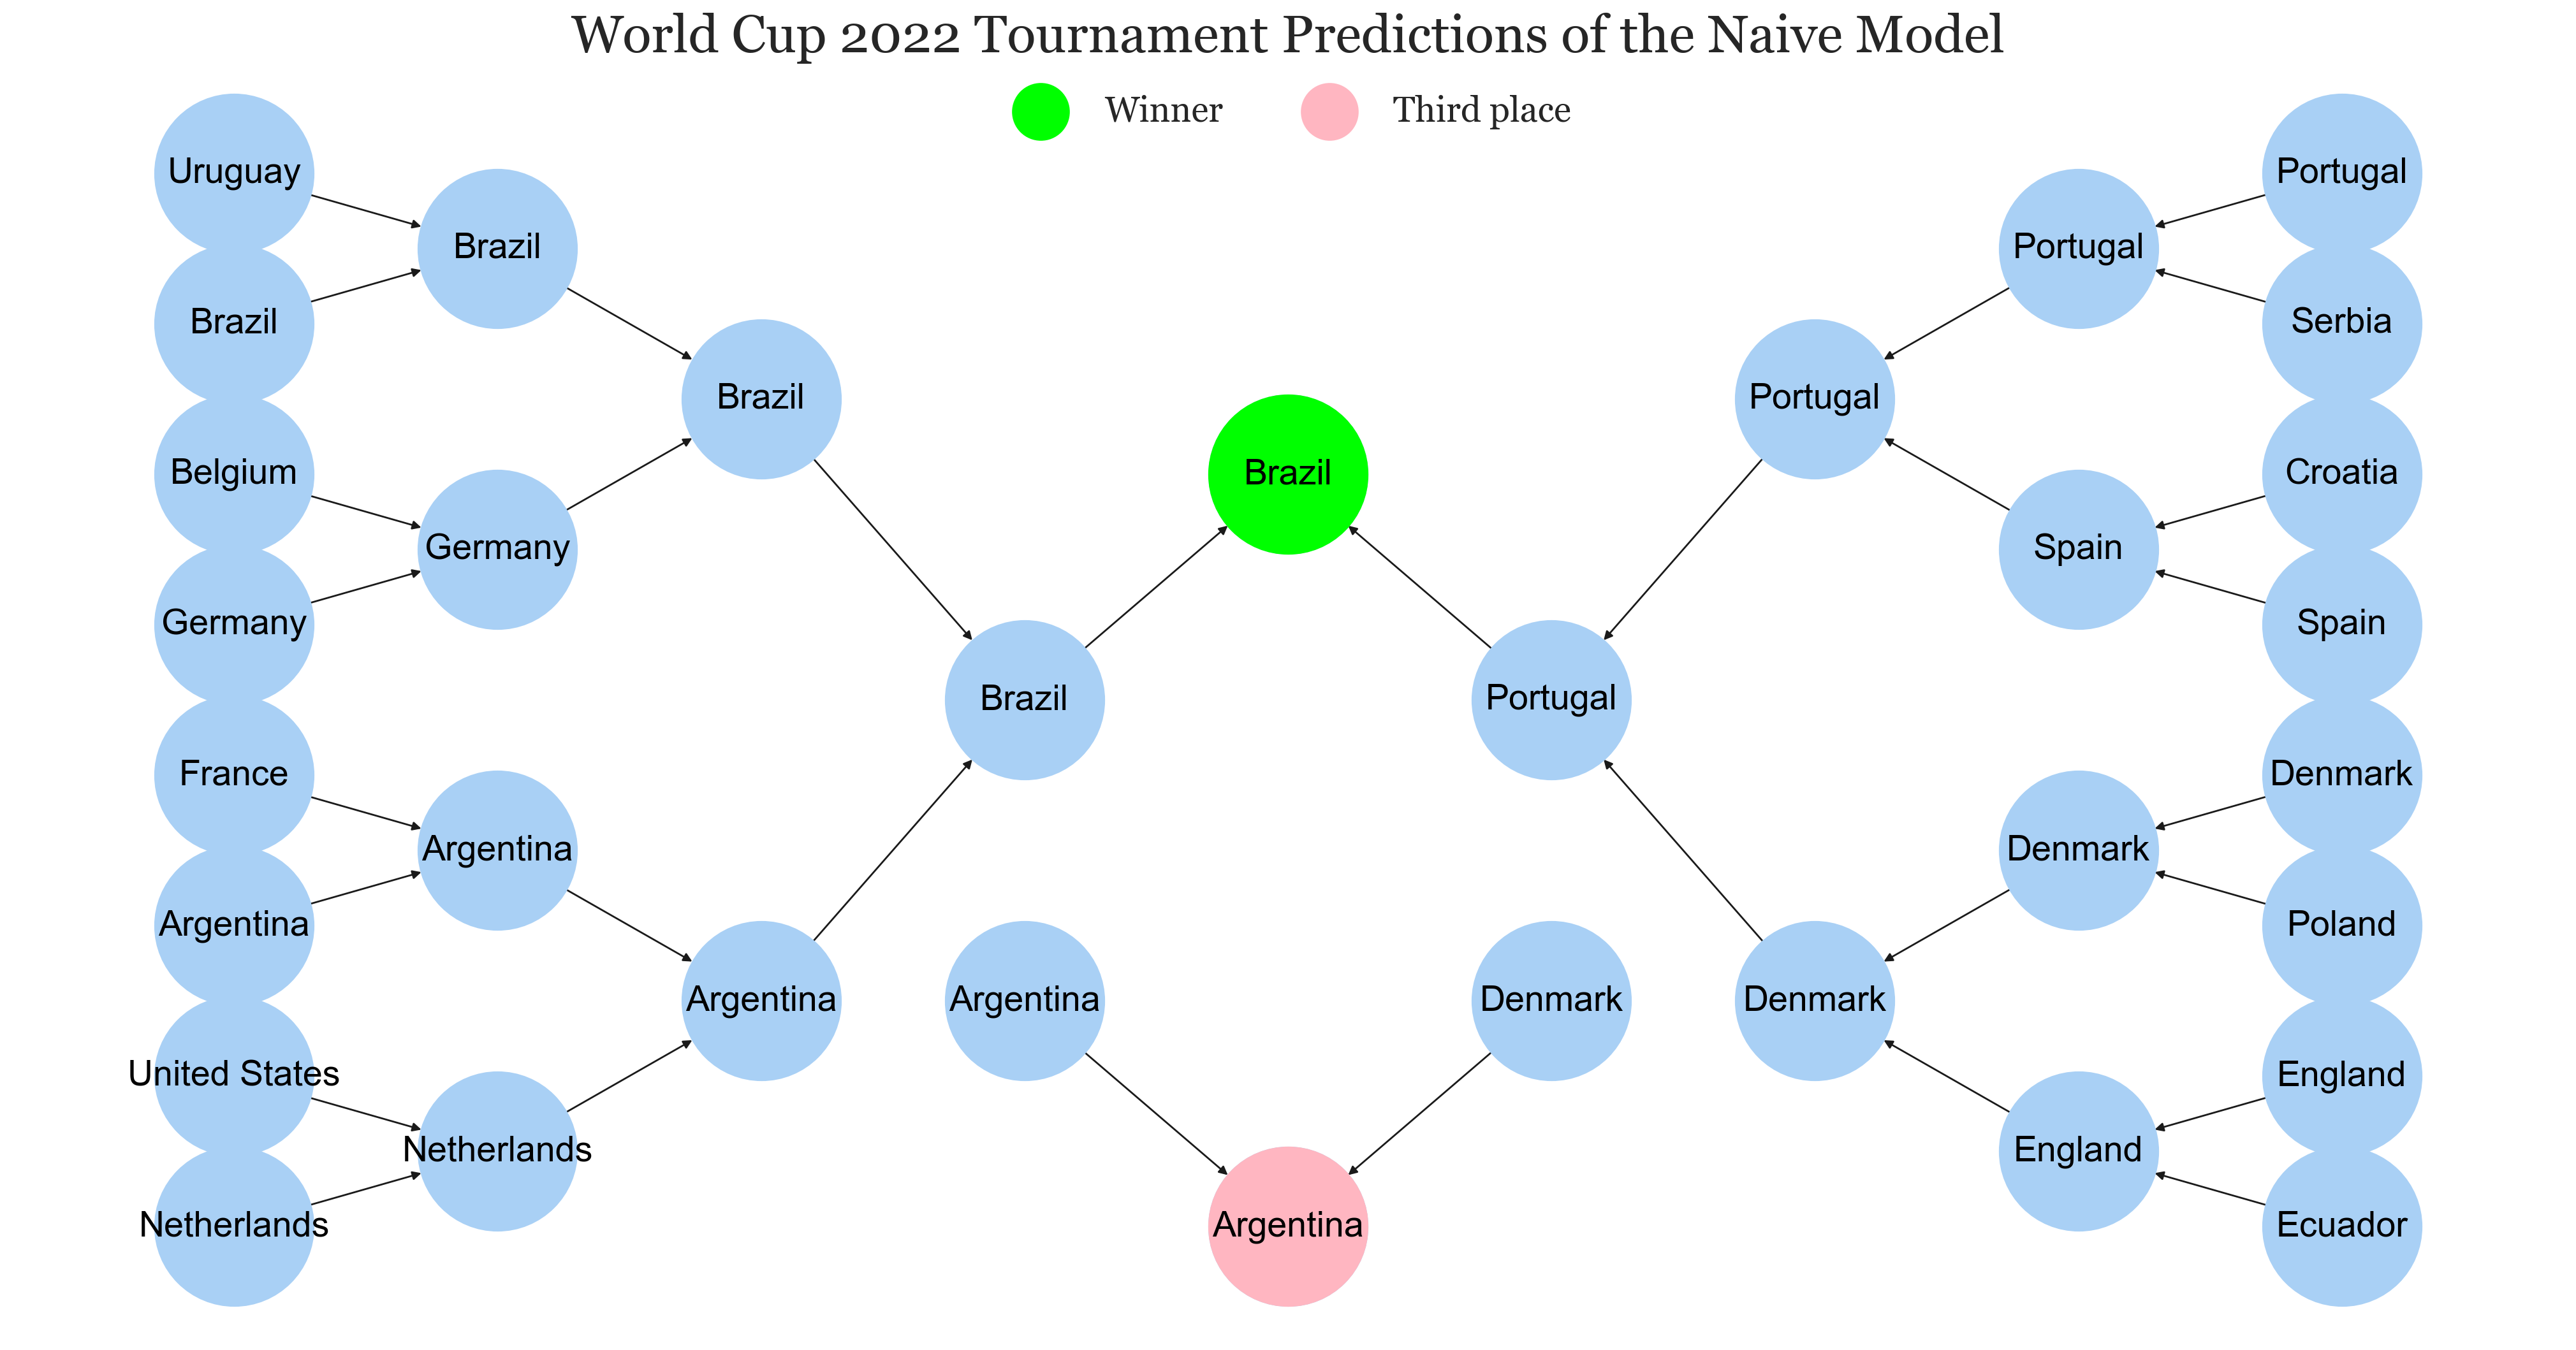

In [81]:
# Visualize the results as a node graph
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# add the nodes a1, b2, c1, d2, e1, f2, g1, h2 to the most left layer of the graph
# add the nodes a2, b1, c2, d1, e2, f1, g2, h1 to the most right layer of the graph
# add the nodes a1b2, c1d2, e1f2, g1h2 to the second left layer of the graph
# add the nodes a2b1, c2d1, e2f1, g2h1 to the second right layer of the graph
# add the nodes a1b2c1d2, e1f2g1h2 to the third left layer of the graph
# add the nodes a2b1c2d1, e2f1g2h1 to the third right layer of the graph
# add the nodes a1b2c1d2e1f2g1h2 to the fourth left layer of the graph
# add the nodes a2b1c2d1e2f1g2h1 to the fourth right layer of the graph
teams = {}
layer_0_team_names = ['a1', 'b2', 'c1', 'd2', 'e1', 'f2', 'g1', 'h2']
layer_8_team_names = ['a2', 'b1', 'c2', 'd1', 'e2', 'f1', 'g2', 'h1']
layer_0_team_names = [winners_group_stage[team_name[0]][int(team_name[1])-1] for team_name in layer_0_team_names]
layer_8_team_names = [winners_group_stage[team_name[0]][int(team_name[1])-1] for team_name in layer_8_team_names]
layer_1_team_names = [winners_round_of_16[team_name] for team_name in ['a1b2', 'c1d2', 'e1f2', 'g1h2']]
layer_2_team_names = [quarter_finals_winners[team_name] for team_name in ['a1b2c1d2', 'e1f2g1h2']]
layer_6_team_names = [quarter_finals_winners[team_name] for team_name in ['a2b1c2d1', 'e2f1g2h1']]
layer_7_team_names = [winners_round_of_16[team_name] for team_name in ['a2b1', 'c2d1', 'e2f1', 'g2h1']]
[G.add_node(team, layer=0, order=i) for team, i in zip(['a1', 'b2', 'c1', 'd2', 'e1', 'f2', 'g1', 'h2'], range(8))]
[G.add_node(team, layer=8, order=i) for team, i in zip(['a2', 'b1', 'c2', 'd1', 'e2', 'f1', 'g2', 'h1'], range(8))]
[G.add_node(team, layer=1, order=.5+2*i) for team, i in zip(['a1b2', 'c1d2', 'e1f2', 'g1h2'], range(4))]
[G.add_node(team, layer=7, order=.5+2*i) for team, i in zip(['a2b1', 'c2d1', 'e2f1', 'g2h1'], range(4))]
[G.add_node(team, layer=2, order=1.5+4*i) for team, i in zip(['a1b2c1d2', 'e1f2g1h2'], range(2))]
[G.add_node(team, layer=6, order=1.5+4*i) for team, i in zip(['a2b1c2d1', 'e2f1g2h1'], range(2))]
G.add_node('a1b2c1d2e1f2g1h2', layer=3, order=3.5)
G.add_node('a2b1c2d1e2f1g2h1', layer=5, order=3.5)
G.add_node('a1b2c1d2e1f2g1h2a2b1c2d1e2f1g2h1', layer=4, order=5)
# add three nodes for the third place teams
G.add_node(third_place_team, layer=3, order=1.5)
G.add_node(fourth_place_team, layer=5, order=1.5)
G.add_node("3rd place:" + third_place_team, layer=4, order=0)

# add to teams dict
teams.update({string: team for string, team in zip(['a1', 'b2', 'c1', 'd2', 'e1', 'f2', 'g1', 'h2'], layer_0_team_names)})
teams.update({string: team for string, team in zip(['a2', 'b1', 'c2', 'd1', 'e2', 'f1', 'g2', 'h1'], layer_8_team_names)})
teams.update({string: team for string, team in zip(['a1b2', 'c1d2', 'e1f2', 'g1h2'], layer_1_team_names)})
teams.update({string: team for string, team in zip(['a2b1', 'c2d1', 'e2f1', 'g2h1'], layer_7_team_names)})
teams.update({string: team for string, team in zip(['a1b2c1d2', 'e1f2g1h2'], layer_2_team_names)})
teams.update({string: team for string, team in zip(['a2b1c2d1', 'e2f1g2h1'], layer_6_team_names)})
teams.update({'a1b2c1d2e1f2g1h2': finalists['a1b2c1d2e1f2g1h2']})
teams.update({'a2b1c2d1e2f1g2h1': finalists['a2b1c2d1e2f1g2h1']})
teams.update({'a1b2c1d2e1f2g1h2a2b1c2d1e2f1g2h1' : winner_of_world_cup})
teams.update({'3rd place:' + third_place_team: third_place_team})
teams.update({third_place_team: third_place_team})
teams.update({fourth_place_team: fourth_place_team})

# add the edges
team1_team2_winner_list_of_tuples = \
    list(zip(['a1', 'c1', 'e1', 'g1'], ['b2', 'd2', 'f2', 'h2'], ['a1b2', 'c1d2', 'e1f2', 'g1h2'])) + \
    list(zip(['a2', 'c2', 'e2', 'g2'], ['b1', 'd1', 'f1', 'h1'], ['a2b1', 'c2d1', 'e2f1', 'g2h1'])) + \
    list(zip(['a1b2', 'e1f2'], ['c1d2', 'g1h2'], ['a1b2c1d2', 'e1f2g1h2'])) + \
    list(zip(['a2b1', 'e2f1'], ['c2d1', 'g2h1'], ['a2b1c2d1', 'e2f1g2h1'])) + \
    list(zip(['a1b2c1d2'], ['e1f2g1h2'], ['a1b2c1d2e1f2g1h2'])) + \
    list(zip(['a2b1c2d1'], ['e2f1g2h1'], ['a2b1c2d1e2f1g2h1'])) + \
    [('a1b2c1d2e1f2g1h2', 'a2b1c2d1e2f1g2h1', 'a1b2c1d2e1f2g1h2a2b1c2d1e2f1g2h1')] + \
    [(third_place_team, fourth_place_team, "3rd place:" + third_place_team)]

for team1, team2, winner in team1_team2_winner_list_of_tuples:
    G.add_edge(team1, winner)
    G.add_edge(team2, winner)

# draw the layers
pos = {}
for node in G.nodes():
    pos[node] = (G.nodes[node]['layer'], G.nodes[node]['order'])
# draw the graph with high dpi  
plt.figure(figsize=(20, 10), dpi=200)
# baby blue nodes
nx.draw(G, pos=pos, labels=teams, node_size=8000, font_size=20, font_color='black', node_color='#A9D0F5', with_labels=True)
# draw the winner in green and write winner above it
nx.draw_networkx_nodes(G, pos=pos, nodelist=['a1b2c1d2e1f2g1h2a2b1c2d1e2f1g2h1'], node_size=8000, node_color='#00FF00')
# draw the third place team in light red
nx.draw_networkx_nodes(G, pos=pos, nodelist=['3rd place:' + third_place_team], node_size=8000, node_color='#FFB6C1')
# add legends for green and light red
plt.scatter([], [], c='#00FF00', s=1000, label='Winner')
plt.scatter([], [], c='#FFB6C1', s=1000, label='Third place')
plt.legend(loc='upper center', ncol=2, fontsize=20, frameon=False)
plt.title('World Cup 2022 Tournament Predictions of the Naive Model', fontsize=30)
# save the image
plt.savefig('world_cup_2022_winner.png', dpi=200)
plt.show()


# Expoloring Different Models

In [82]:
df_individual_reverse = pd.read_csv('df_individual_reverse.csv')
df_individual_reverse = df_individual_reverse.drop('Unnamed: 0', axis = 1)
X_individual_reverse = df_individual_reverse.drop(['Winner', 'match', 'Year'], axis = 1)
y_individual_reverse = df_individual_reverse['Winner']

In [83]:
df_individual_reverse.head()

,match,GK Home,GK Away,FW Home,FW Away,MF Home,MF Away,DF Home,DF Away,backup Home,backup Away,Year,Winner
0,South Africa-Mexico,72.000,71.0,65.000,74.175,69.673,68.382,69.282,74.333,63.410,65.504,2010,1
1,Mexico-South Africa,71.000,72.0,74.175,65.000,68.382,69.673,74.333,69.282,65.504,63.410,2010,1
2,Uruguay-France,81.000,88.0,77.667,73.561,77.264,77.671,76.000,78.333,65.269,66.197,2010,1
3,France-Uruguay,88.000,81.0,73.561,77.667,77.671,77.264,78.333,76.000,66.197,65.269,2010,1
4,South Korea-Greece,65.556,74.0,70.852,73.667,65.556,70.750,66.037,75.667,64.111,63.917,2010,2


In [84]:
# We seperate the test data. We will not touch it. It will be used to compare different models.
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 109)

In [85]:
# We seperate the test data. We will not touch it. It will be used to compare different models.
X_train, X_test, y_train, y_test = train_test_split(X_individual_reverse, y_individual_reverse, test_size=0.25, random_state = 109)

In [86]:
model_dic = {}
#dictiionary for models. In the form {model1: {mse_acc : ..., test_acc: ..., model_func: ...}, model2: ..., ...}

In [87]:
X_train.head()

,GK Home,GK Away,FW Home,FW Away,MF Home,MF Away,DF Home,DF Away,backup Home,backup Away
405,83.0,78.0,86.667,75.879,82.250,77.25,83.000,79.333,75.083,72.000
63,74.0,72.0,71.711,79.667,75.817,81.00,69.089,87.333,65.867,65.917
126,76.0,72.0,80.333,79.667,71.875,81.00,73.583,87.333,66.833,65.917
378,84.0,69.0,75.667,66.333,79.250,74.00,78.667,74.333,74.853,65.229
257,73.0,73.0,74.000,83.333,77.750,83.00,75.000,85.000,63.167,68.439


In [88]:
y_train.head()

405    2
63     0
126    0
378    1
257    1
Name: Winner, dtype: int64


## <div class='exercise'>FIRST MODEL: Straighforward Logistic Regression with Three Independent Classes</div> 

In [89]:
LR = LogisticRegression(max_iter = 10000, fit_intercept = False)
LR.fit(X_train, y_train)
LR_predict_proba = LR.predict_proba(X_train)
LR_predict_proba = pd.DataFrame(LR_predict_proba, columns = ['0', '1', '2'])
LR_pred = pd.Series(LR.predict(X_train), name = 'Winner')

In [90]:
accuracy_score(LR_pred,y_train)

0.5512820512820513

In [91]:
CV1 = cross_validate(LR, X_train, y_train, cv=5, scoring = 'accuracy', return_train_score = True)
print(CV1)
print(CV1['train_score'].mean())
print(CV1['test_score'].mean())

{'fit_time': array([0.02276087, 0.02500415, 0.02469182, 0.02038789, 0.01725078]), 'score_time': array([0.00173426, 0.00124383, 0.00152302, 0.00148225, 0.00146723]), 'test_score': array([0.53968254, 0.50793651, 0.51612903, 0.51612903, 0.59677419]), 'train_score': array([0.562249  , 0.57831325, 0.576     , 0.576     , 0.548     ])}
0.5681124497991968
0.5353302611367127


In [92]:
accuracy_score(LR.predict(X_test),y_test)

0.5288461538461539

In [93]:
MODELS = pd.DataFrame([['Logistic Regression', accuracy_score(LR_pred,y_train), accuracy_score(LR.predict(X_test),y_test)]], columns = ['Model', 'Train Score', 'Test Score'])
display(MODELS)

,Model,Train Score,Test Score
0,Logistic Regression,0.551,0.529


In [94]:
MODEL_NAME = ['Logistic Regression']
TRAIN_SCORE = [accuracy_score(LR_pred,y_train)]
TEST_SCORE = [accuracy_score(LR.predict(X_test),y_test)]

## <div class='exercise'>SECOND MODEL: Threshold Model (we create it from scratch)</div> 

In [95]:
def new_dummies(y):
    '''
    given a response variable that takes values 0,1,2
    returns two dummies y_01 and y_12
    y_01: 0 if y == 0; 1 if y== 1 or 2
    y_12: 0 if y==0 or 1; 1 if y==2
    '''
    y_01 = y.copy()
    y_01 = y_01.replace(2, 1)
    
    y_12 = y.copy()
    y_12 = y_12.replace(1,0)
    y_12 = y_12.replace(2,1)
    return y_01, y_12

In [96]:
class ThresholdModel(ClassifierMixin):
    def __init__(self, threshold):
        self.threshold = threshold
        self.func = None
        self.func_proba = None
        
    def fit(self, X, y):
        threshold = self.threshold
        y_01, y_12 = new_dummies(y)
        LR_01 = LogisticRegression(max_iter = 16000)
        LR_01.fit(X, y_01)
        LR_12 = LogisticRegression(max_iter = 16000)
        LR_12.fit(X, y_12)
            
        def func_proba(X_new):
            pred_01 = pd.DataFrame(LR_01.predict_proba(X_new), columns = ['0', '12'])
            pred_12 = pd.DataFrame(LR_12.predict_proba(X_new), columns = ['01', '2'])
            probs = pred_01.copy().drop('12', axis=1)
            probs['1'] = pred_12['01'] - pred_01['0']
            probs['2'] = pred_12['2']
            
            return probs
            
        self.func_proba = func_proba
        
        def threshold_func(X_new):
            pred = self.func_proba(X_new)
            threshold = self.threshold
            pred.loc[pred['0'] - pred['2'] > threshold, 'Win'] = 0
            pred.loc[pred['2'] - pred['0']> threshold, 'Win'] = 2
            pred = pred.fillna(1)

            return pred['Win']
            
        self.func = threshold_func
        
            
    def predict(self, X):
        return self.func(X)
    
    def predict_proba(self, X):
        return self.func_proba(X)
    
    def get_params(self, deep = False):
        return {'threshold': self.threshold}
    
    def set_params(self, value):
        setattr(self, threshold, value)
        return self
    
        
            

In [97]:
model2_options = []
model2_train_accuracies = []
model2_val_accuracies = []
thresholds = []
for i in range(0,100):
    thresholds.append(i/1000)
for threshold in thresholds:
    predictor=ThresholdModel(threshold)
    CV2 = cross_validate(predictor, X_train, y_train, cv=5, return_train_score=True, scoring = 'accuracy')
    model2_options.append(predictor)
    model2_train_accuracies.append(CV2['train_score'].mean())
    model2_val_accuracies.append(CV2['test_score'].mean())
     

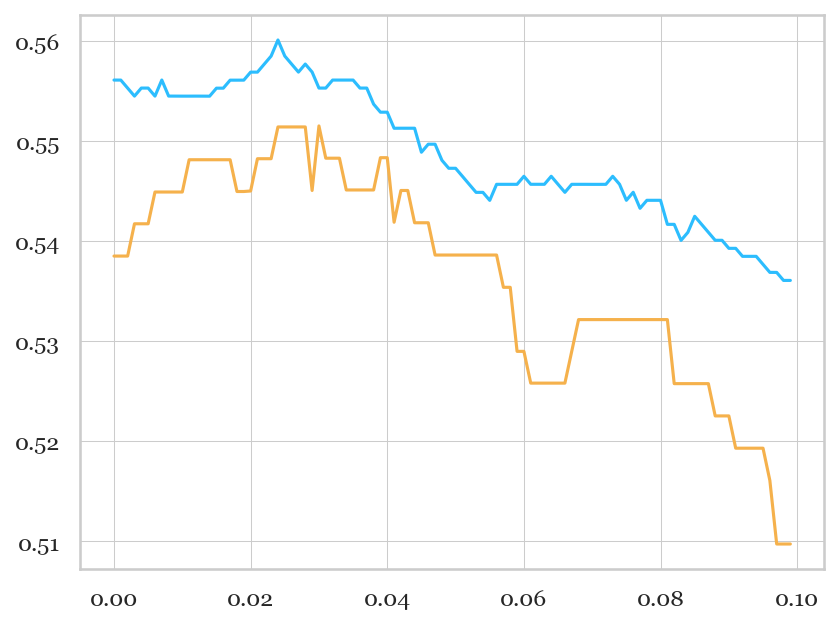

In [98]:
plt.plot(thresholds, model2_train_accuracies)
plt.plot(thresholds, model2_val_accuracies)

In [99]:
print(np.max(model2_train_accuracies))
print(np.max(model2_val_accuracies))

0.5600963855421687
0.551510496671787


In [100]:
print(np.argmax(model2_train_accuracies))
print(np.argmax(model2_val_accuracies))

24
30


In [101]:
best_threshold = (np.argmax(model2_val_accuracies) + 1)/1000
best_model2 = ThresholdModel(best_threshold)
best_model2.fit(X_train, y_train)
print(accuracy_score(best_model2.predict(X_train), y_train))
print(accuracy_score(best_model2.predict(X_test), y_test))

0.5544871794871795
0.5288461538461539


In [102]:
MODEL_NAME.append('Threshold = ' + str(best_threshold))
TRAIN_SCORE.append(accuracy_score(best_model2.predict(X_train), y_train))
TEST_SCORE.append(accuracy_score(best_model2.predict(X_test), y_test))

## <div class='exercise'>THIRD MODEL: Decision Tree</div> 

Text(0.5, 1.0, 'Depth vs. Accuracy in Train Data - Zoomed in')

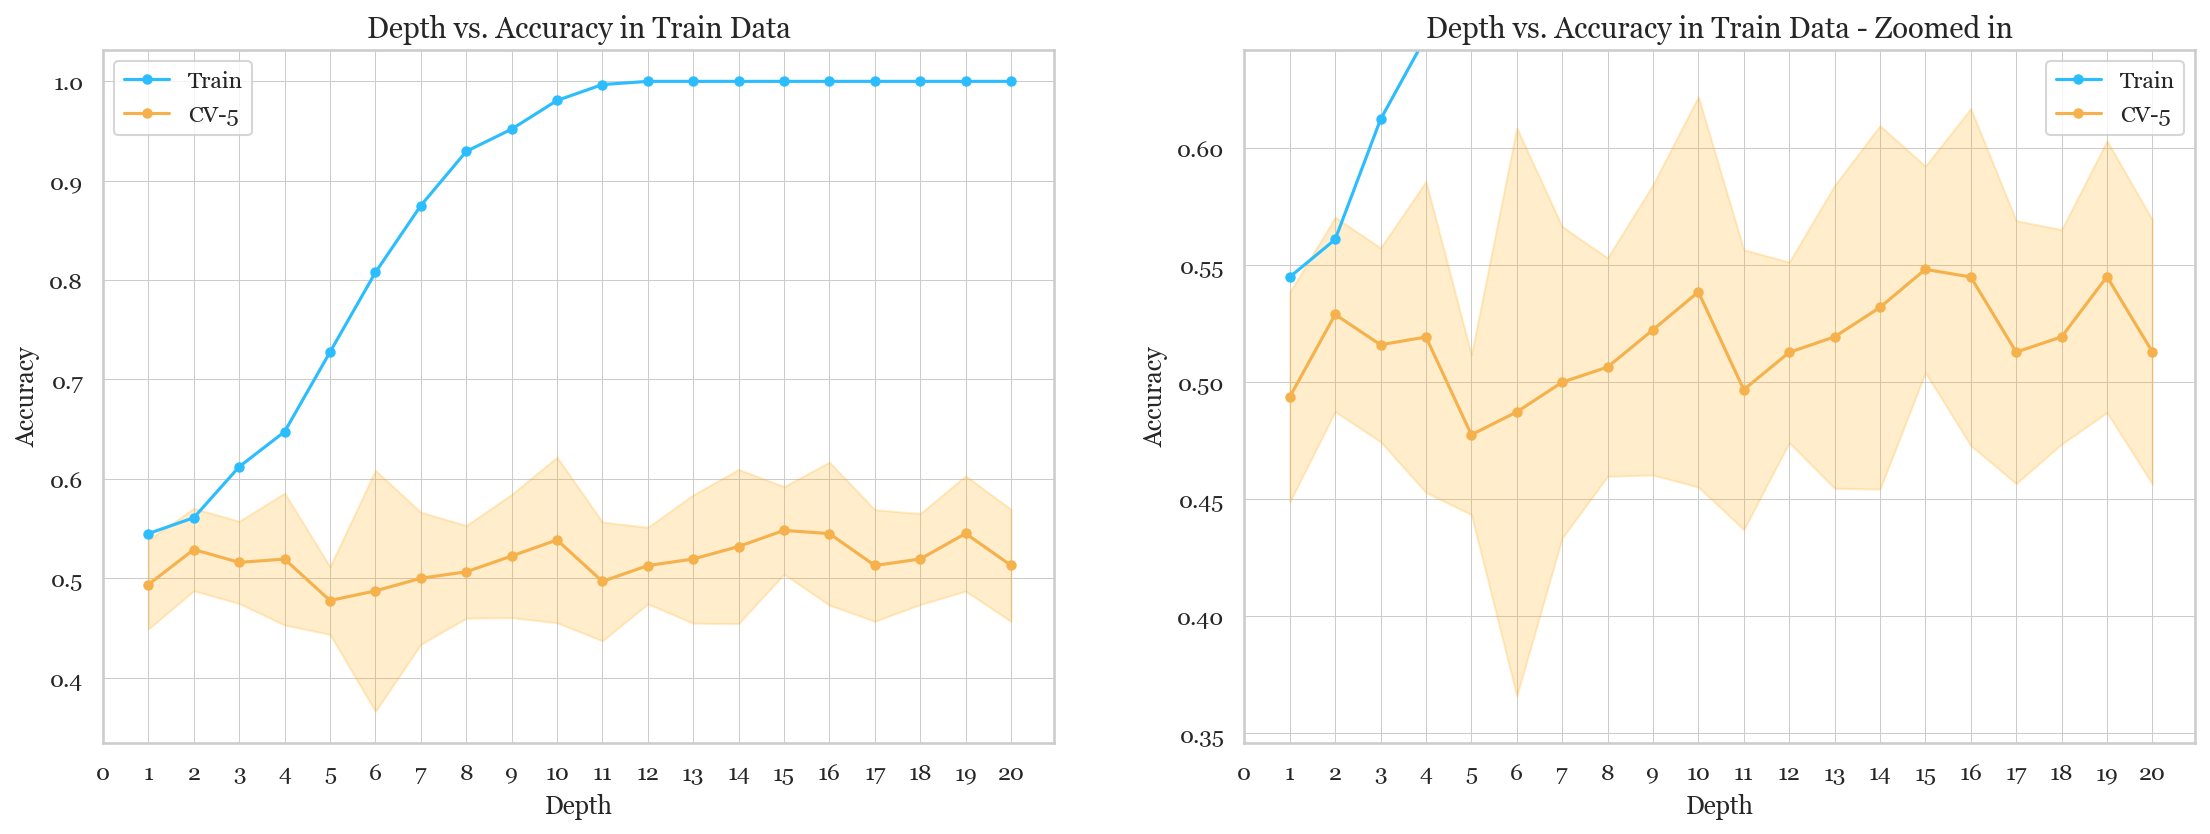

In [103]:
cvmeans = []
cvstds = []
train_scores = []
for d in range(1,21):
    dtree = DecisionTreeClassifier(max_depth = d, criterion = 'gini')
    dtree.fit(X_train, y_train)
    train_scores.append(dtree.score(X_train, y_train))
    cvscores = cross_val_score(dtree, X_train, y_train, cv=5)
    cvmeans.append(cvscores.mean())
    cvstds.append(cvscores.std())

cvmeans = pd.Series(cvmeans)
cvstds = pd.Series(cvstds)   

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (18,6))
axes = axes.ravel()

for ax in axes:
    ax.plot(range(1, 21), train_scores, label = "Train", marker = 'o', markersize = 4)
    ax.plot(range(1, 21), cvmeans, label = "CV-5", marker = 'o', markersize = 4)
    ax.fill_between(x = np.arange(1,21,step=1), y1 = cvmeans - 2*cvstds, y2 = cvmeans + 2*cvstds, alpha = 0.2, color = 'orange')
    ax.legend()
    ax.set_xticks(ticks = np.arange(0, 21, step=1))
    ax.set_xlabel('Depth')
    ax.set_ylabel('Accuracy')

#set the limits for the second graph
axes[1].set_ylim(ymin = np.min(cvmeans - 2*cvstds) - 0.02, ymax = np.max(cvmeans + 2*cvstds) + 0.02)

#title for the graphs
axes[0].set_title('Depth vs. Accuracy in Train Data')
axes[1].set_title('Depth vs. Accuracy in Train Data - Zoomed in')

In [104]:
# your code here
# choose best depth after a qualitative assessment of our plots
best_cv_depth = np.argmax(cvmeans)+1

dtree = DecisionTreeClassifier(max_depth = best_cv_depth, criterion = 'gini')
dtree.fit(X_train, y_train)
    
best_cv_tree_train_score = accuracy_score(dtree.predict(X_train), y_train)
best_cv_tree_test_score = accuracy_score(dtree.predict(X_test), y_test)

In [105]:
# print model results summary
print(
    "The tree of max-depth {} trained on the "
    "full training set, achieves the following accuracy scores:"
    "\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}".format(
        best_cv_depth,
        best_cv_tree_train_score,
        best_cv_tree_test_score,
    )
)

The tree of max-depth 15 trained on the full training set, achieves the following accuracy scores:

	train	1.0000
	TEST	0.5385


In [106]:
MODEL_NAME.append('Decision Tree, depth = ' + str(best_cv_depth))
TRAIN_SCORE.append(best_cv_tree_train_score)
TEST_SCORE.append(best_cv_tree_test_score)

## <div class='exercise'>FOURTH MODEL: Bagging for Decision Tree</div> 

In [107]:
# COPT-PASTED FROM HW6

def bagger(
    n_trees: int,
    tree_depth: int,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    random_seed: int = 0,
) -> (pd.DataFrame, pd.DataFrame, list):
    """Generate boostrapped DecisionTreeClassifier predictions
    
    Function fits bootstrapped DecisionTreeClassifier models
    and returns training and test predictions for each of those
    bootstrapped models, along with the fitted model objects as
    described in Question 2.2 question text.
    
    :param n_trees: int, number of bootstrapped decision trees
    :param tree_depth: int, maximum tree depth
    :param X_train: np.ndarray, training X observations
    :param y_train: np.ndarray, training y observations
    :param X_test: np.ndarray, test X observations
    :param random_seed: int, random seed used to set np.random.seed
                        to ensure replicable results (default=0)
    
    :returns: (pd.DataFrame, pd.DataFrame, list), tuple containing 3
              objects, (1) bagging_train_df dataframe
              as described in Q2.2 question text, (2) bagging_test_df
              dataframe as described in Q2.2, and (3) bagging_models_list
              containing every trained DecisionTreeClassifier model
              object (i.e. estimator), one estimator for each bootstrap
              (you will need this list later in Q3.2)
    """
    
    # set random seed for replicable results
    np.random.seed(random_seed)
    
    # instantiate arrays and list for storing results
    bagging_train = np.zeros((X_train.shape[0], n_trees)).astype(int)
    bagging_test = np.zeros((X_test.shape[0], n_trees)).astype(int)

    bagging_models_list = []

    # perform n bootstraps
    for i in range(n_trees):
        # generate bootstrapped model
        bootstrapped_X, bootstrapped_y = resample(X_train, y_train)
        fitted_model = DecisionTreeClassifier(
            max_depth=tree_depth
        ).fit(bootstrapped_X, bootstrapped_y)
        bagging_models_list.append(fitted_model)

        # predict on full training and test sets and store
        # results to arrays
        bagging_train[:,i] = fitted_model.predict(X_train)
        bagging_test[:,i] = fitted_model.predict(X_test)
    
    # convert arrays to pandas dataframes as required
    bagging_train_df = pd.DataFrame(
        bagging_train[:, :],
        columns=[f"model{x}" for x in range(n_trees)],
    )
    bagging_test_df = pd.DataFrame(
        bagging_test[:, :],
        columns=[f"model{x}" for x in range(n_trees)],
    )
    
    return bagging_train_df, bagging_test_df, bagging_models_list
    

In [108]:
n_trees = 250
tree_depth = best_cv_depth

In [109]:
bagging_train_df, bagging_test_df , bagging_models_list = bagger(n_trees, tree_depth, X_train, y_train, X_test)

In [110]:
# display resulting dataframe heads
display(bagging_train_df.head())
display(bagging_test_df.head())

,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15,model16,model17,model18,model19,model20,model21,model22,model23,model24,...,model225,model226,model227,model228,model229,model230,model231,model232,model233,model234,model235,model236,model237,model238,model239,model240,model241,model242,model243,model244,model245,model246,model247,model248,model249
0,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,1,2,2,2,2,...,2,2,2,2,2,2,2,2,1,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2
1,2,0,0,0,0,2,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,0,2,0,0,0,2,0,0,0,0,...,0,0,0,2,0,0,0,0,0,2,0,0,0,2,2,0,0,0,0,2,2,0,0,0,2
3,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,...,2,1,1,1,1,1,1,1,2,0,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,0,1,0,1,1,1,1,1,1,1,...,0,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1


,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12,model13,model14,model15,model16,model17,model18,model19,model20,model21,model22,model23,model24,...,model225,model226,model227,model228,model229,model230,model231,model232,model233,model234,model235,model236,model237,model238,model239,model240,model241,model242,model243,model244,model245,model246,model247,model248,model249
0,0,1,0,0,0,2,2,0,2,2,0,0,2,0,1,2,0,0,0,0,0,0,0,0,0,...,0,0,2,0,2,0,0,0,0,1,2,2,0,0,0,0,0,0,2,0,0,0,0,0,0
1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,1,2,2,...,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,2,0,0,0,0
4,0,0,0,2,0,2,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1,2,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [111]:
#classifications
train_classes = pd.DataFrame(np.ones(len(bagging_train_df)).T, columns = ['classification'])
train_classes.loc[bagging_train_df.mean(axis=1)>1.05, 'classification'] = 2
train_classes.loc[bagging_train_df.mean(axis=1)<0.95, 'classification'] = 0

test_classes = pd.DataFrame(np.ones(len(bagging_test_df)).T, columns = ['classification'])
test_classes.loc[bagging_test_df.mean(axis=1)>1.05, 'classification'] = 2
test_classes.loc[bagging_test_df.mean(axis=1)<0.95, 'classification'] = 0

#evaluate accuracy on our bagged prediction results
bagging_accuracy_train = accuracy_score(train_classes['classification'], y_train)
bagging_accuracy_test = accuracy_score(test_classes['classification'], y_test)

In [112]:
# print summary of results
print(
    f"Bagging {n_trees} trees of depth-{tree_depth} achieves "
    f"the following accuracy scores:\n\n\ttrain\t"
    f"{bagging_accuracy_train:.4f}\n\tTEST\t"
    f"{bagging_accuracy_test:.4f}\n"
)
print(
    f"Our prior single depth-{best_cv_depth} tree achieved a "
    f"TEST score of {best_cv_tree_test_score:.4f}."
)

Bagging 250 trees of depth-15 achieves the following accuracy scores:

	train	0.8622
	TEST	0.5769

Our prior single depth-15 tree achieved a TEST score of 0.5385.


In [113]:
MODEL_NAME.append('Bagging Decision Tree, depth = ' + str(best_cv_depth))
TRAIN_SCORE.append(bagging_accuracy_train)
TEST_SCORE.append(bagging_accuracy_test)

NOW, let us try to change the "epsilon" for the threshold. It was +- 0.05 above

In [114]:
model3_options = []
model3_train_accuracies = []
model3_test_accuracies = []
epsilons = []
for i in range(0,1000):
    epsilons.append(i/1000)
for eps in epsilons:
    train_classes = pd.DataFrame(np.ones(len(bagging_train_df)).T, columns = ['classification'])
    train_classes.loc[bagging_train_df.mean(axis=1)>1 + eps, 'classification'] = 2
    train_classes.loc[bagging_train_df.mean(axis=1)<1 - eps, 'classification'] = 0

    test_classes = pd.DataFrame(np.ones(len(bagging_test_df)).T, columns = ['classification'])
    test_classes.loc[bagging_test_df.mean(axis=1)>1 + eps, 'classification'] = 2
    test_classes.loc[bagging_test_df.mean(axis=1)<1 - eps, 'classification'] = 0

    #evaluate accuracy on our bagged prediction results
    bagging_accuracy_train = accuracy_score(train_classes['classification'], y_train)
    bagging_accuracy_test = accuracy_score(test_classes['classification'], y_test)
    
    model3_train_accuracies.append(bagging_accuracy_train)
    model3_test_accuracies.append(bagging_accuracy_test)

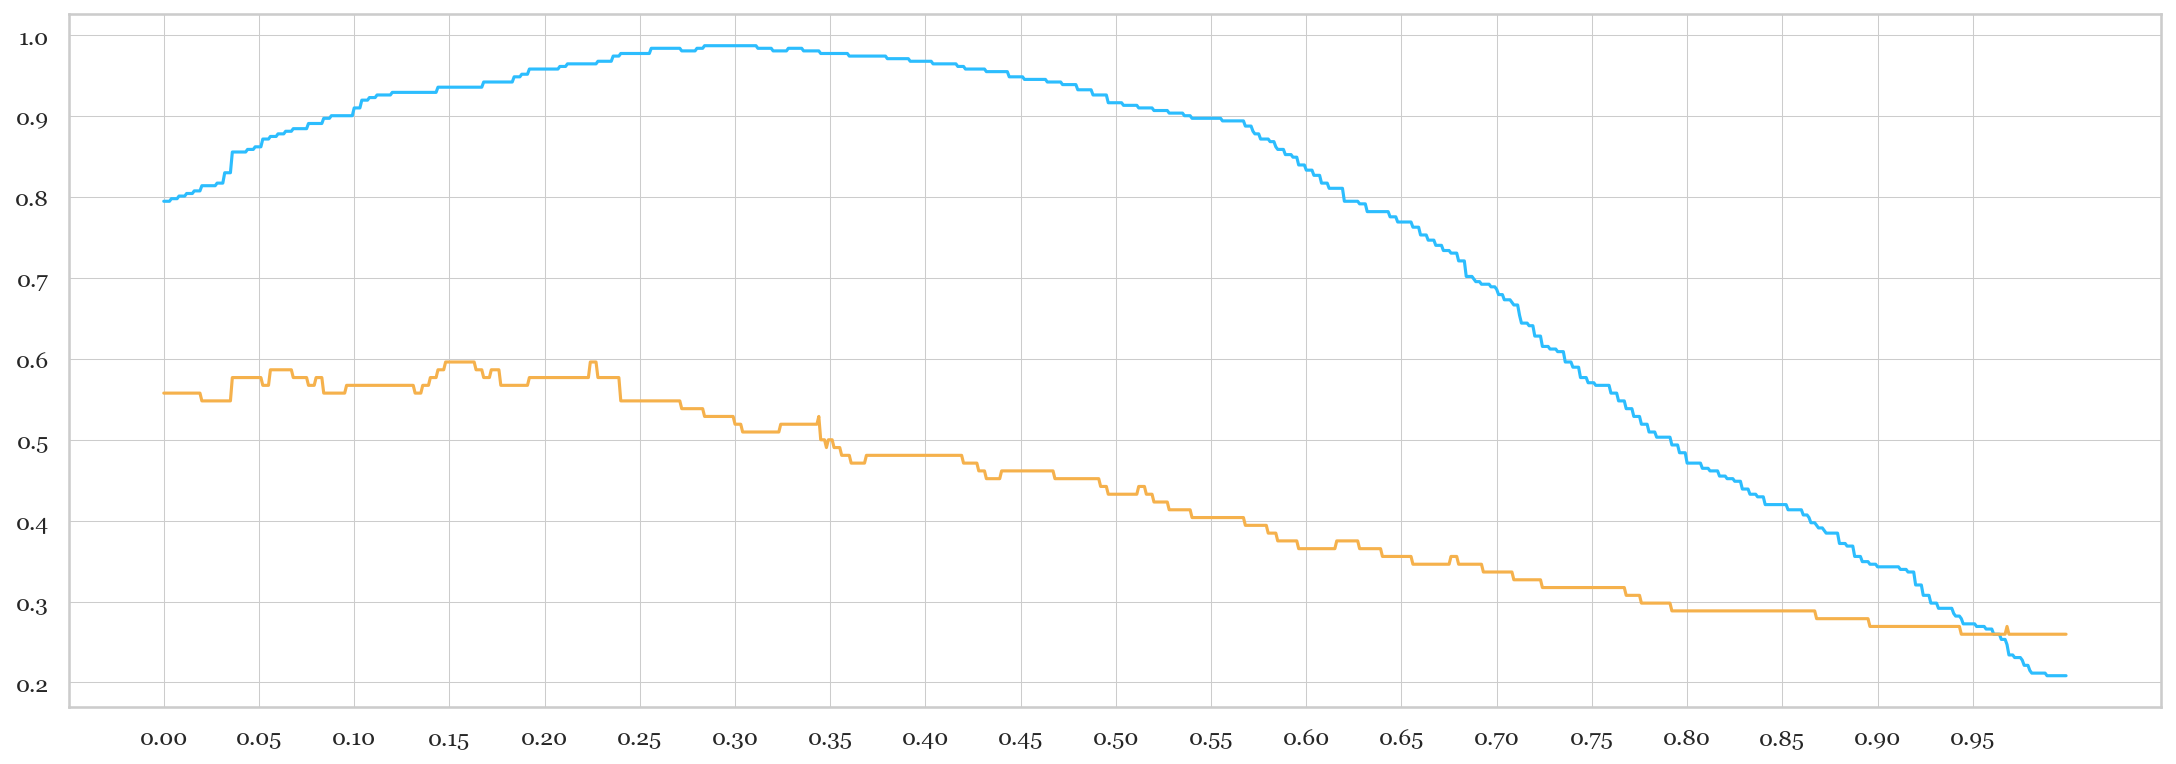

In [115]:
ticks = []
for i in range(0,20):
    ticks.append(i/20)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (18,6))
plt.plot(epsilons, model3_train_accuracies)
plt.plot(epsilons, model3_test_accuracies)
plt.xticks(ticks = ticks);

## <div class='exercise'>FIFTH MODEL: Random Forest</div> 

In [116]:
cvmeans = []
train_scores = []
for d in range(20):
    rf = RandomForestClassifier(max_depth = d+1,
                               max_features = 'sqrt',
                               oob_score = False,
                               random_state = 0,
                               n_estimators = n_trees)
   

    rf.fit(X_train, y_train)
    train_scores.append(dtree.score(X_train, y_train))
    cvscores = cross_val_score(dtree, X_train, y_train, cv=5)
    cvmeans.append(cvscores.mean())



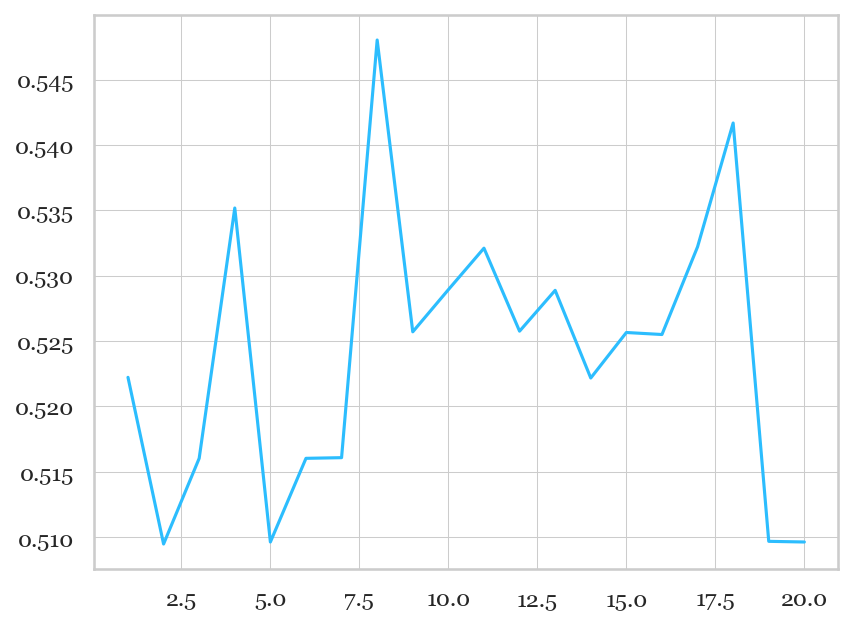

In [117]:
plt.plot(range(1,21), cvmeans)

In [118]:
best_depth = np.argmax(cvmeans)+1
rf = RandomForestClassifier(max_depth = best_depth,
                           max_features = 'sqrt',
                           oob_score = False,
                           random_state = 0,
                           n_estimators = n_trees)
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=8, n_estimators=250, random_state=0)

In [119]:
# evaluate results
random_forest_train_score = rf.score(X_train, y_train)
random_forest_test_score = rf.score(X_test, y_test)

In [120]:
# print results summary
print(
    "The random forest of depth-{} and {} trees achieves the "
    "following accuracy scores:\n\n\ttrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(
        tree_depth,
        n_trees,
        random_forest_train_score,
        random_forest_test_score,
    )
)

The random forest of depth-15 and 250 trees achieves the following accuracy scores:

	train	0.9936
	TEST	0.5962


In [121]:
MODEL_NAME.append('Random Forest, depth = ' + str(best_depth))
TRAIN_SCORE.append(random_forest_train_score)
TEST_SCORE.append(random_forest_test_score)

## <div class='exercise'>CONCLUSION: Choice of the Model</div> 

In [122]:
MODELS_df = pd.DataFrame()
MODELS_df['Model'] = MODEL_NAME
MODELS_df['Train Score'] = TRAIN_SCORE
MODELS_df['Test Score'] = TEST_SCORE
display(MODELS_df)

,Model,Train Score,Test Score
0,Logistic Regression,0.551,0.529
1,Threshold = 0.031,0.554,0.529
2,"Decision Tree, depth = 15",1.000,0.538
3,"Bagging Decision Tree, depth = 15",0.862,0.577
4,"Random Forest, depth = 8",0.994,0.596


We choose the random forest.

If you want to use it, just do rf.predict()


The models we tried:
1) Simple Logistic Regression = 0.529
2) Threshold Model we created = 0.529
3) Simple Decision Tree = 0.577
3) Decision Tree with Bagging = 0.577
4) Random Forest = 0.596

Note that this is not a binary classification problem. We have three classes.

If you want to use rf to make binary choices, you can look at rf.predict_proba(X) and choose the higher probability among 2 and 0.\
Note that 2 means home wins, 1 means draw, 0 means away wins.

Don't hesitate contacting me (Suat) in case of an issue with the modeling or questions related to this jupyter notebook.\
For questions regarding the dataset, please contact

In [123]:
# setting the best model
MODEL = rf

# Simulating the 2022 World Cup

We use our random forest model to simulate the 2022 World Cup, by predicting the results of the matches and propagating the results to the next round, until we have a winner.

In [124]:
# getting the dataframes of the matches of the 2022 world cup
df_teams_scores_2022 = pd.read_csv('score_2022.csv')
df_teams_scores_2022.drop(['Unnamed: 0', 'score'], axis=1, inplace=True)
print('df_teams_scores_2022 has {} rows and {} columns'.format(df_teams_scores_2022.shape[0], df_teams_scores_2022.shape[1]))
display(df_teams_scores_2022.head())

df_teams_scores_2022 has 32 rows and 6 columns


,country,GK,FW,MF,DF,backup
0,Ecuador,71.0,71.000,73.75,68.567,65.033
1,Netherlands,74.0,81.333,79.00,85.000,69.867
2,Qatar,72.0,64.917,64.75,65.583,61.683
3,Senegal,76.0,73.542,76.00,81.000,66.175
4,England,83.0,86.667,77.42,83.000,71.067


# The Simulation of the 2022 World Cup with Our Random Forest Model

In [125]:
def get_match_row(team1, team2):
    """
    :param team1: the name of the first team
    :param team2: the name of the second team

    :return: a dataframe with one row and 10 columns
        [GK Home, GK Away, FW Home, FW Away, MF Home, MF Away, DF Home, DF Away, backup Home, backup Away]
    """
    team1_row = df_teams_scores_2022[df_teams_scores_2022['country'] == team1].drop('country', axis=1).reset_index(drop=True)
    team2_row = df_teams_scores_2022[df_teams_scores_2022['country'] == team2].drop('country', axis=1).reset_index(drop=True)
    team1_row = team1_row.add_suffix(' Home') # add the " Home" suffix to the columns of team1
    team2_row = team2_row.add_suffix(' Away') # add the " Away" suffix to the columns of team2
    unordered_row = pd.concat([team1_row, team2_row], axis=1) # concatenate the two rows into one row
    ordered_row = unordered_row[['GK Home', 'GK Away', 'FW Home', 'FW Away', 'MF Home', 'MF Away', 'DF Home', 'DF Away', 'backup Home', 'backup Away']]
    return ordered_row

# test on Qatar and Saudi Arabia
display(get_match_row('Qatar', 'Saudi Arabia'))

,GK Home,GK Away,FW Home,FW Away,MF Home,MF Away,DF Home,DF Away,backup Home,backup Away
0,72.0,71.0,64.917,68.551,64.75,71.5,65.583,70.333,61.683,60.487


In [126]:
# write a function that returns the top 2 teams in the each of the 8 groups
# but each match uses the rf model to predict the winner, using rf.predict_proba().
# rf.predict_proba()[2] is the probability of the home team winning
# rf.predict_proba()[0] is the probability of the away team winning
# the winner is the team with the highest probability of winning
def get_group_winners(df_groups):
    """
    :param df_groups: a dataframe with 3 columns: Home Team, Away Team, Group

    :return: a dictionary with the top 2 teams in each group, named a1, a2, b1, b2, etc.
    """
    winners_group_stage = {}
    for group in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']:
        # df_groups has columns Home Team, Away Team, Group
        group_df = df_groups[df_groups['Group'] == group]
        home_teams_df = group_df['Home Team']
        away_teams_df = group_df['Away Team']

        # keep track of the points of each team
        group_teams_names = set(home_teams_df.values) | set(away_teams_df.values)
        points = {team : 0 for team in group_teams_names}

        # for each match, get the probabilities of the home team winning, the away team winning, and a draw
        for team1, team2 in zip(home_teams_df, away_teams_df):
            match_df = get_match_row(team1, team2)
            away_draw_home_probs = MODEL.predict_proba(match_df)[0]
            if away_draw_home_probs[1] == max(away_draw_home_probs): # if the max is a draw
                points[team1] += 1
                points[team2] += 1            
            elif away_draw_home_probs[2] == max(away_draw_home_probs): 
                points[team1] += 3 # if the max is a home win
            else: 
                points[team2] += 3 # if the max is an away win

        # get the top 2 teams in the group
        group_winners = sorted(points, key=points.get, reverse=True)[:2]
        winners_group_stage[group + "1"] = group_winners[0]
        winners_group_stage[group + "2"] = group_winners[1]

    return winners_group_stage

groups_winners = get_group_winners(df_groups)

In [127]:
# function that takes in a list of matches and a dictionary of players
# and returns the winners of the matches, using rf.predict_proba()
def get_round_winners(matches, players):
    """
    :param matches: a list of tuples of the form (team1, team2)
    :param players: a dictionary of the form {team1: player1, team2: player2}

    :return: 
        a dictionary of the form {match: {winner: player, probability: prob, loser: player}}
        where `prob` is the probability of the winner winning, calculated as
        prob = prob of winning / (prob of winning + prob of losing)
    """

    winners = {}

    for match in matches:
        home_team = players[match[0]]
        away_team = players[match[1]]
        match_df = get_match_row(home_team, away_team)
        away_draw_home_probs = MODEL.predict_proba(match_df)[0]
        home_team_prob = away_draw_home_probs[2]
        away_team_prob = away_draw_home_probs[0]

        # print(home_team, away_team, away_draw_home_probs)

        if home_team_prob > away_team_prob:
            prob_of_win = home_team_prob / (home_team_prob + away_team_prob)
            winners[match[0] + match[1]] = {'winner': home_team, 'probability': prob_of_win, 'loser': away_team}
        else:
            prob_of_win = away_team_prob / (home_team_prob + away_team_prob)
            winners[match[0] + match[1]] = {'winner': away_team, 'probability': prob_of_win, 'loser': home_team}

    return winners

In [128]:
# round of 16
round_of_16_matches = [
    ('a1', 'b2'), ('c1', 'd2'), ('e1', 'f2'), ('g1', 'h2'),
    ('a2', 'b1'), ('c2', 'd1'), ('e2', 'f1'), ('g2', 'h1'),
]
round_of_16_dict = get_round_winners(round_of_16_matches, groups_winners)
round_of_16_winners = {match: round_of_16_dict[match]['winner'] for match in round_of_16_dict}
round_of_16_winners

{'a1b2': 'Netherlands',
 'c1d2': 'Argentina',
 'e1f2': 'Germany',
 'g1h2': 'Brazil',
 'a2b1': 'England',
 'c2d1': 'France',
 'e2f1': 'Belgium',
 'g2h1': 'Serbia'}

In [129]:
# quarter finals
quarter_finals_matches = [
    ('a1b2', 'c1d2'), 
    ('a2b1', 'c2d1'), 
    ('e1f2', 'g1h2'), 
    ('e2f1', 'g2h1')
]

quarter_finals_dict = get_round_winners(quarter_finals_matches, round_of_16_winners)
quarter_finals_winners = {match: quarter_finals_dict[match]['winner'] for match in quarter_finals_dict}
quarter_finals_winners

{'a1b2c1d2': 'Argentina',
 'a2b1c2d1': 'France',
 'e1f2g1h2': 'Germany',
 'e2f1g2h1': 'Belgium'}

In [130]:
# semi finals
semi_finals_matches = [
    ('a1b2c1d2', 'e1f2g1h2'), 
    ('a2b1c2d1', 'e2f1g2h1')
]

semi_finals_dict = get_round_winners(semi_finals_matches, quarter_finals_winners)
semi_finals_winners = {match: semi_finals_dict[match]['winner'] for match in semi_finals_dict}
semi_finals_winners

{'a1b2c1d2e1f2g1h2': 'Germany', 'a2b1c2d1e2f1g2h1': 'Belgium'}

In [131]:
# final
final_match = [('a1b2c1d2e1f2g1h2', 'a2b1c2d1e2f1g2h1')]
finals_dict = get_round_winners(final_match, semi_finals_winners)
winner_of_world_cup = finals_dict[final_match[0][0] + final_match[0][1]]['winner']
second_place_team = finals_dict[final_match[0][0] + final_match[0][1]]['loser']
winner_of_world_cup

'Belgium'

In [132]:
# third place players are the losers of the semi finals
third_place_players = {
    'left_team': semi_finals_dict['a1b2c1d2e1f2g1h2']['loser'],
    'right_team': semi_finals_dict['a2b1c2d1e2f1g2h1']['loser']
}
third_place_dict = get_round_winners([('left_team', 'right_team')], third_place_players)
third_place_team = third_place_dict['left_teamright_team']['winner']
fourth_place_team = third_place_dict['left_teamright_team']['loser']
third_place_dict

print(f"The winner of the world cup is {winner_of_world_cup}!")
print(f"2nd place:                     {second_place_team}")
print(f"3rd place:                     {third_place_team}")
print(f"4th place:                     {fourth_place_team}")

The winner of the world cup is Belgium!
2nd place:                     Germany
3rd place:                     France
4th place:                     Argentina


# Visualizing the Tournament Results

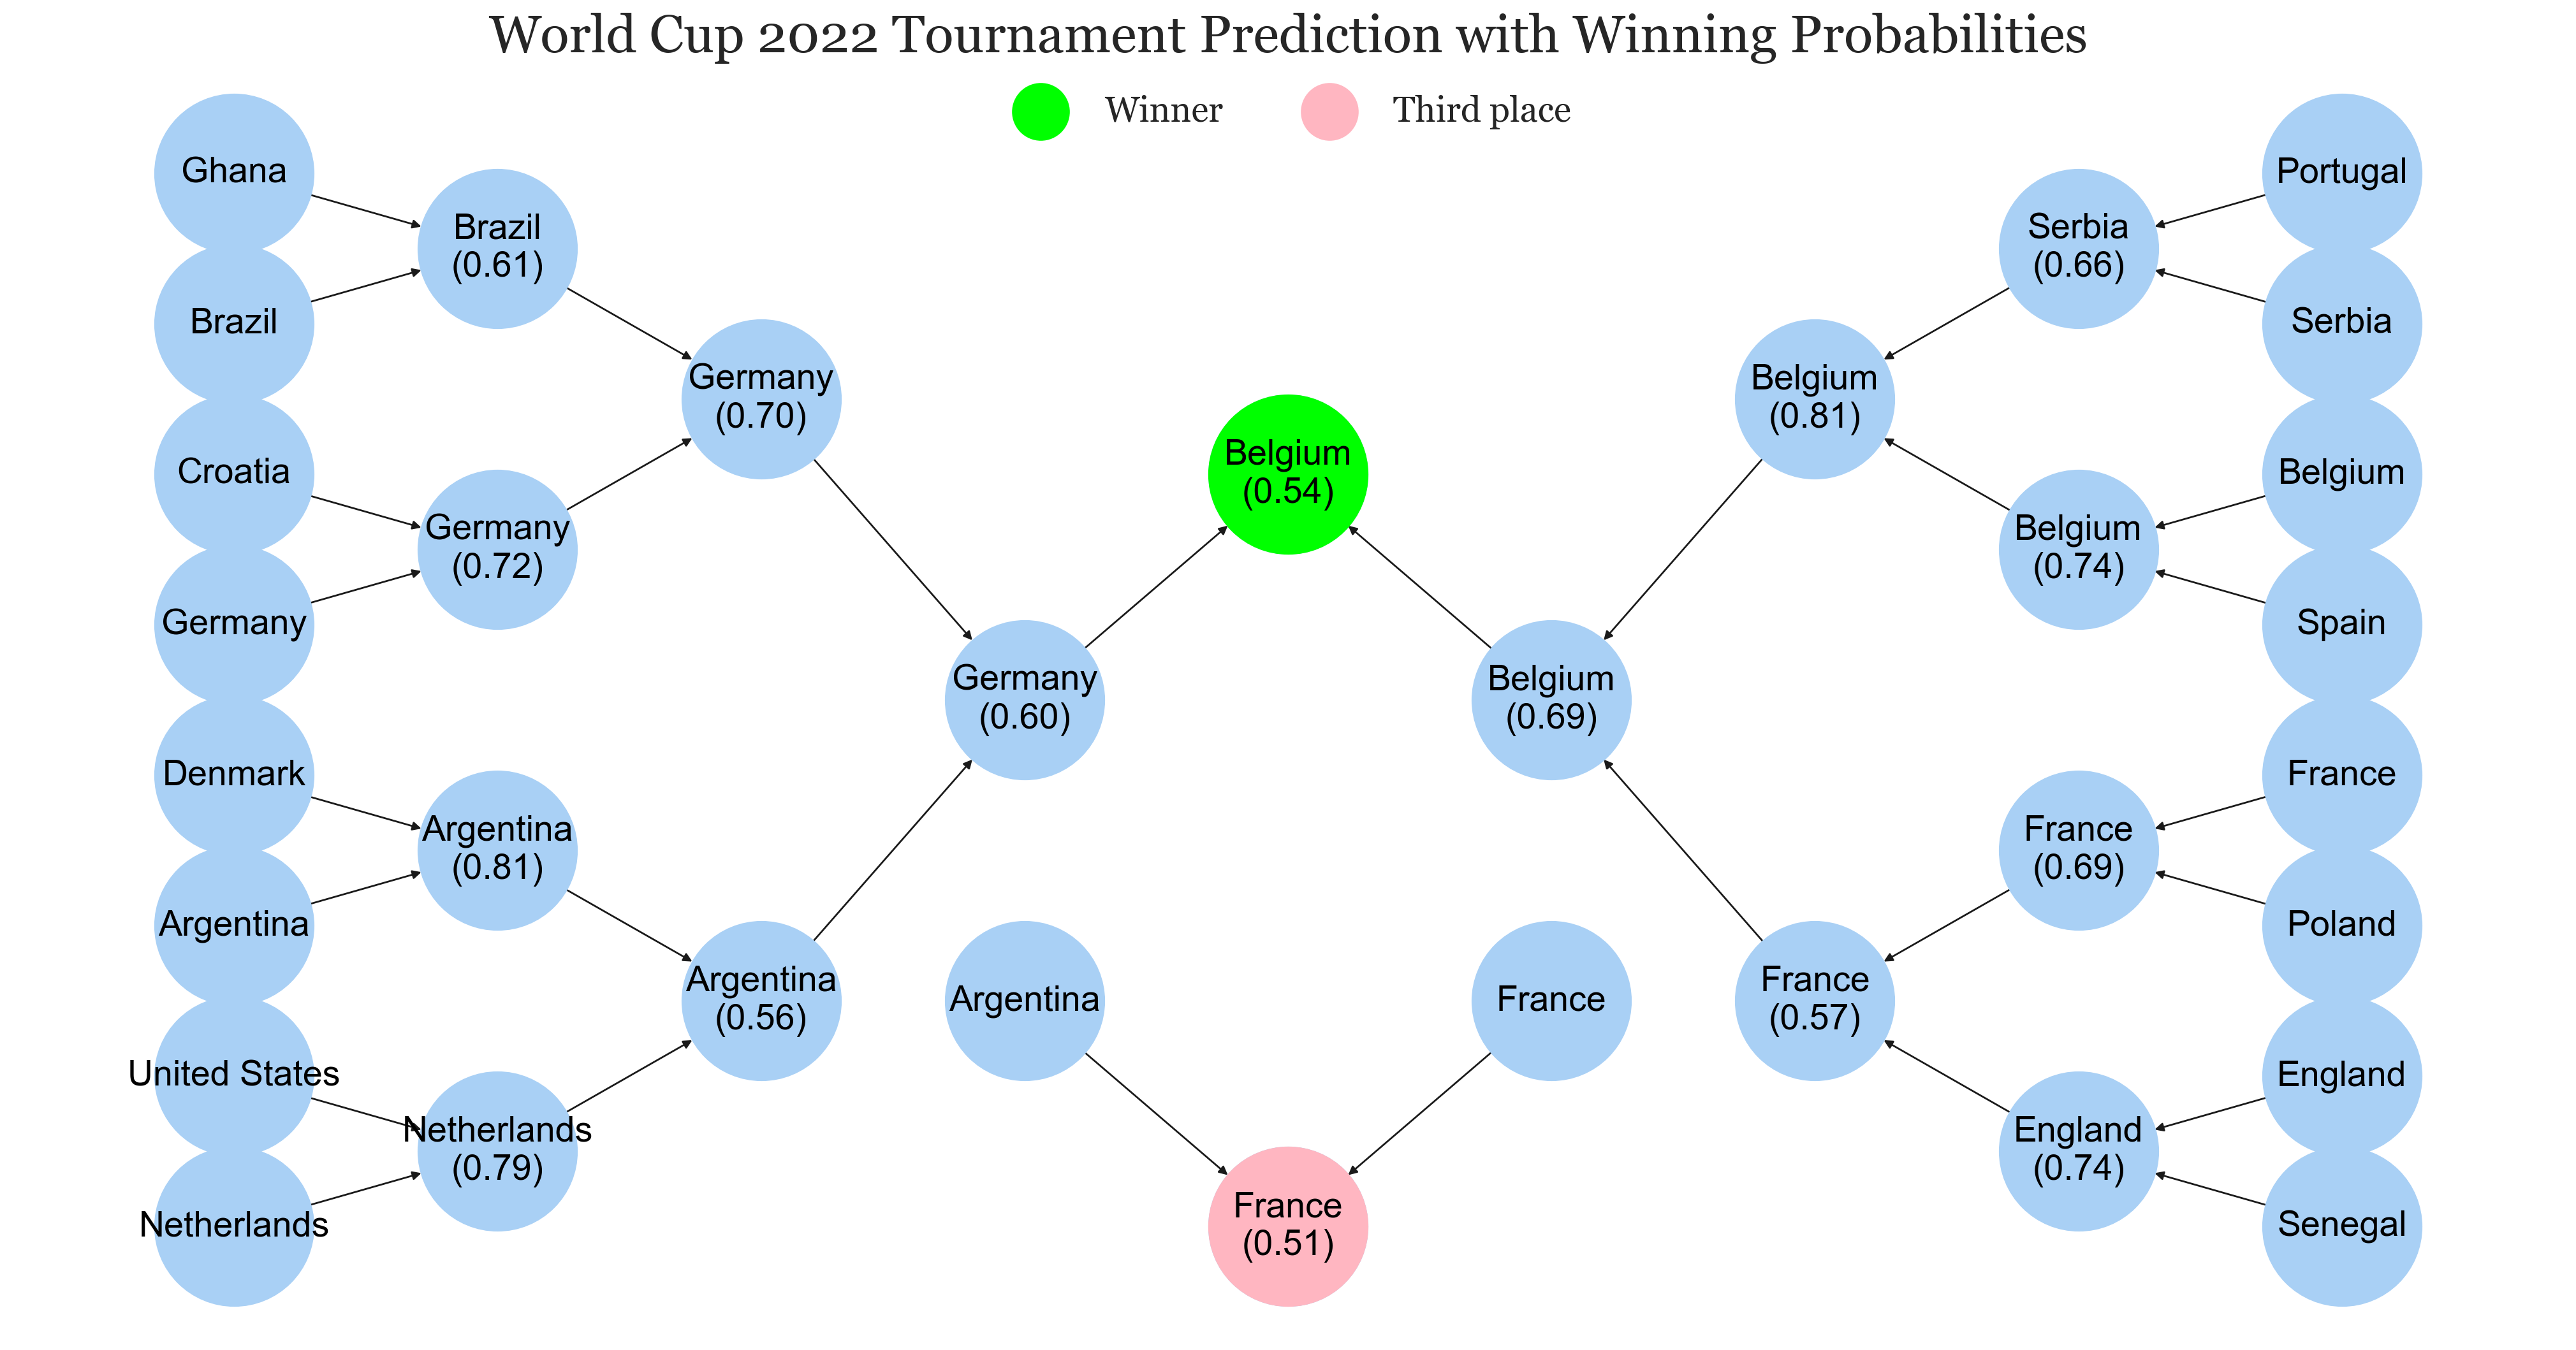

In [133]:
# Visualize the results as a node graph
import networkx as nx
import matplotlib.pyplot as plt


G = nx.DiGraph()

# add the nodes a1, b2, c1, d2, e1, f2, g1, h2 to the most left layer of the graph
# add the nodes a2, b1, c2, d1, e2, f1, g2, h1 to the most right layer of the graph
# add the nodes a1b2, c1d2, e1f2, g1h2 to the second left layer of the graph
# add the nodes a2b1, c2d1, e2f1, g2h1 to the second right layer of the graph
# add the nodes a1b2c1d2, e1f2g1h2 to the third left layer of the graph
# add the nodes a2b1c2d1, e2f1g2h1 to the third right layer of the graph
# add the nodes a1b2c1d2e1f2g1h2 to the fourth left layer of the graph
# add the nodes a2b1c2d1e2f1g2h1 to the fourth right layer of the graph
teams = {}
layer_0_team_names = ['a1', 'b2', 'c1', 'd2', 'e1', 'f2', 'g1', 'h2']
layer_8_team_names = ['a2', 'b1', 'c2', 'd1', 'e2', 'f1', 'g2', 'h1']
layer_0_team_names = [groups_winners[team_name] for team_name in layer_0_team_names]
layer_8_team_names = [groups_winners[team_name] for team_name in layer_8_team_names]
layer_1_team_names = [f"{round_of_16_winners[team_name]}\n({round_of_16_dict[team_name]['probability']:.2f})" for team_name in ['a1b2', 'c1d2', 'e1f2', 'g1h2']]
layer_7_team_names = [f"{round_of_16_winners[team_name]}\n({round_of_16_dict[team_name]['probability']:.2f})" for team_name in ['a2b1', 'c2d1', 'e2f1', 'g2h1']]
layer_2_team_names = [f"{quarter_finals_winners[team_name]}\n({quarter_finals_dict[team_name]['probability']:.2f})" for team_name in ['a1b2c1d2', 'e1f2g1h2']]
layer_6_team_names = [f"{quarter_finals_winners[team_name]}\n({quarter_finals_dict[team_name]['probability']:.2f})" for team_name in ['a2b1c2d1', 'e2f1g2h1']]
[G.add_node(team, layer=0, order=i) for team, i in zip(['a1', 'b2', 'c1', 'd2', 'e1', 'f2', 'g1', 'h2'], range(8))]
[G.add_node(team, layer=8, order=i) for team, i in zip(['a2', 'b1', 'c2', 'd1', 'e2', 'f1', 'g2', 'h1'], range(8))]
[G.add_node(team, layer=1, order=.5+2*i) for team, i in zip(['a1b2', 'c1d2', 'e1f2', 'g1h2'], range(4))]
[G.add_node(team, layer=7, order=.5+2*i) for team, i in zip(['a2b1', 'c2d1', 'e2f1', 'g2h1'], range(4))]
[G.add_node(team, layer=2, order=1.5+4*i) for team, i in zip(['a1b2c1d2', 'e1f2g1h2'], range(2))]
[G.add_node(team, layer=6, order=1.5+4*i) for team, i in zip(['a2b1c2d1', 'e2f1g2h1'], range(2))]
G.add_node('a1b2c1d2e1f2g1h2', layer=3, order=3.5)
G.add_node('a2b1c2d1e2f1g2h1', layer=5, order=3.5)
G.add_node('a1b2c1d2e1f2g1h2a2b1c2d1e2f1g2h1', layer=4, order=5)
# add three nodes for the third place teams
G.add_node(third_place_players['left_team'], layer=3, order=1.5)
G.add_node(third_place_players['right_team'], layer=5, order=1.5)
G.add_node("3rd place:" + third_place_team, layer=4, order=0)

# add to teams dict
teams.update({string: team for string, team in zip(['a1', 'b2', 'c1', 'd2', 'e1', 'f2', 'g1', 'h2'], layer_0_team_names)})
teams.update({string: team for string, team in zip(['a2', 'b1', 'c2', 'd1', 'e2', 'f1', 'g2', 'h1'], layer_8_team_names)})
teams.update({string: team for string, team in zip(['a1b2', 'c1d2', 'e1f2', 'g1h2'], layer_1_team_names)})
teams.update({string: team for string, team in zip(['a2b1', 'c2d1', 'e2f1', 'g2h1'], layer_7_team_names)})
teams.update({string: team for string, team in zip(['a1b2c1d2', 'e1f2g1h2'], layer_2_team_names)})
teams.update({string: team for string, team in zip(['a2b1c2d1', 'e2f1g2h1'], layer_6_team_names)})
teams.update({'a1b2c1d2e1f2g1h2': f"{semi_finals_winners['a1b2c1d2e1f2g1h2']}\n({semi_finals_dict['a1b2c1d2e1f2g1h2']['probability']:.2f})"})
teams.update({'a2b1c2d1e2f1g2h1': f"{semi_finals_winners['a2b1c2d1e2f1g2h1']}\n({semi_finals_dict['a2b1c2d1e2f1g2h1']['probability']:.2f})"})
teams.update({'a1b2c1d2e1f2g1h2a2b1c2d1e2f1g2h1' : f"{winner_of_world_cup}\n({finals_dict['a1b2c1d2e1f2g1h2a2b1c2d1e2f1g2h1']['probability']:.2f})"})
teams.update({'3rd place:' + third_place_team: f"{third_place_team}\n({third_place_dict['left_teamright_team']['probability']:.2f})"})
teams.update({third_place_team: third_place_team})
teams.update({fourth_place_team: fourth_place_team})

# add the edges
team1_team2_winner_list_of_tuples = \
    list(zip(['a1', 'c1', 'e1', 'g1'], ['b2', 'd2', 'f2', 'h2'], ['a1b2', 'c1d2', 'e1f2', 'g1h2'])) + \
    list(zip(['a2', 'c2', 'e2', 'g2'], ['b1', 'd1', 'f1', 'h1'], ['a2b1', 'c2d1', 'e2f1', 'g2h1'])) + \
    list(zip(['a1b2', 'e1f2'], ['c1d2', 'g1h2'], ['a1b2c1d2', 'e1f2g1h2'])) + \
    list(zip(['a2b1', 'e2f1'], ['c2d1', 'g2h1'], ['a2b1c2d1', 'e2f1g2h1'])) + \
    list(zip(['a1b2c1d2'], ['e1f2g1h2'], ['a1b2c1d2e1f2g1h2'])) + \
    list(zip(['a2b1c2d1'], ['e2f1g2h1'], ['a2b1c2d1e2f1g2h1'])) + \
    [('a1b2c1d2e1f2g1h2', 'a2b1c2d1e2f1g2h1', 'a1b2c1d2e1f2g1h2a2b1c2d1e2f1g2h1')] + \
    [(third_place_team, fourth_place_team, "3rd place:" + third_place_team)]

for team1, team2, winner in team1_team2_winner_list_of_tuples:
    G.add_edge(team1, winner)
    G.add_edge(team2, winner)

# draw the layers
pos = {}
for node in G.nodes():
    pos[node] = (G.nodes[node]['layer'], G.nodes[node]['order'])
# draw the graph with high dpi  
plt.figure(figsize=(20, 10), dpi=200)
# baby blue nodes
nx.draw(G, pos=pos, labels=teams, node_size=8000, font_size=20, font_color='black', node_color='#A9D0F5', with_labels=True)
# draw the winner in green and write winner above it
nx.draw_networkx_nodes(G, pos=pos, nodelist=['a1b2c1d2e1f2g1h2a2b1c2d1e2f1g2h1'], node_size=8000, node_color='#00FF00')
# draw the third place team in light red
nx.draw_networkx_nodes(G, pos=pos, nodelist=['3rd place:' + third_place_team], node_size=8000, node_color='#FFB6C1')
# add legends for green and light red
plt.scatter([], [], c='#00FF00', s=1000, label='Winner')
plt.scatter([], [], c='#FFB6C1', s=1000, label='Third place')
# add legend for the probability of winning, indicating that the probability is written between parantheses
plt.legend(loc='upper center', ncol=2, fontsize=20, frameon=False)
plt.scatter([], [], c='white', s=1, label='(<Probability of winning>)')
plt.title('World Cup 2022 Tournament Prediction with Winning Probabilities', fontsize=30)

# save the image
plt.savefig('world_cup_2022_winner.png', dpi=200)
plt.show()


In [134]:
# use elastic net regularization
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# train the model
model = ElasticNet()
parameters = {'alpha': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000], 'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]}
grid = GridSearchCV(model, parameters, cv=5)
grid.fit(X_train, y_train)

# predict the results
y_pred = grid.predict(X_test)

# print scores of the model
print('Test Error:', grid.score(X_test, y_test))


Test Error: 0.1349530463520383


In [135]:
# multiclass boosting
from sklearn.ensemble import GradientBoostingClassifier

# train the model
model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=800, max_depth=5, max_features='sqrt', random_state=0)
model.fit(X_train, y_train)

# predict the results
y_pred = model.predict(X_test)

# print scores of the model
print('Test Error:', accuracy_score(y_test, y_pred))

Test Error: 0.5384615384615384


In [136]:
# use xgboost
import xgboost as xgb

# train the model
model = xgb.XGBClassifier(learning_rate=0.01, n_estimators=800, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective='multi:softmax', nthread=4, scale_pos_weight=1, seed=27)
model.fit(X_train, y_train)

# predict the results
y_pred = model.predict(X_test)

# print scores of the model
print('Test Error:', accuracy_score(y_test, y_pred))

[19:19:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

Test Error: 0.5288461538461539


In [145]:
# Balance the dataset with synthetic samples (SMOTE)
from imblearn.over_sampling import SMOTE

# train the model
model = xgb.XGBClassifier(learning_rate=0.01, n_estimators=800, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective='multi:softmax', nthread=4, scale_pos_weight=3, seed=27)
sm = SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
model.fit(X_train_res, y_train_res)
# model.fit(X_train, y_train)

# predict the results
y_pred = model.predict(X_test)

# print scores of the model
print('Test Error:', accuracy_score(y_test, y_pred))

[19:31:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

Test Error: 0.5673076923076923


In [144]:
# gradient boosting with SMOTE
from sklearn.ensemble import GradientBoostingClassifier

# train the model
model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=800, max_depth=5, max_features='sqrt', random_state=0)
sm = SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
model.fit(X_train_res, y_train_res)

# predict the results
y_pred = model.predict(X_test)

# print scores of the model
print('Test Error:', accuracy_score(y_test, y_pred))

Test Error: 0.5480769230769231


In [138]:
# elastic net with decision tree
from sklearn.tree import DecisionTreeRegressor
# import ada boost
from sklearn.ensemble import AdaBoostRegressor

# initiate the model with elastic net regularization
model = ElasticNet()
# do boosting with elastic net as the base model
# model = AdaBoostRegressor(base_estimator=model, n_estimators=800, learning_rate=0.01, loss='square', random_state=0)
# do boosting with decision tree as the base model
model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5), n_estimators=800, learning_rate=0.01, loss='square', random_state=0)
model.fit(X_train, y_train)

# predict the results
y_pred = model.predict(X_test)

# print scores of the model
print('Test Error:', model.score(X_test, y_test))



Test Error: 0.19231762019432574


In [139]:
# # xgboost grid search
# from sklearn.model_selection import GridSearchCV

# # train the model
# model = xgb.XGBClassifier()

# parameters = {'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [200, 700, 1000], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'min_child_weight': [1, 3, 5, 7], 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], 'objective': ['multi:softmax'], 'nthread': [4], 'scale_pos_weight': [1, 3, 5, 7, 9], 'seed': [27]}
# grid = GridSearchCV(model, parameters, cv=5)
# grid.fit(X_train, y_train)

# # predict the results
# y_pred = grid.predict(X_test)

# Feature Importance

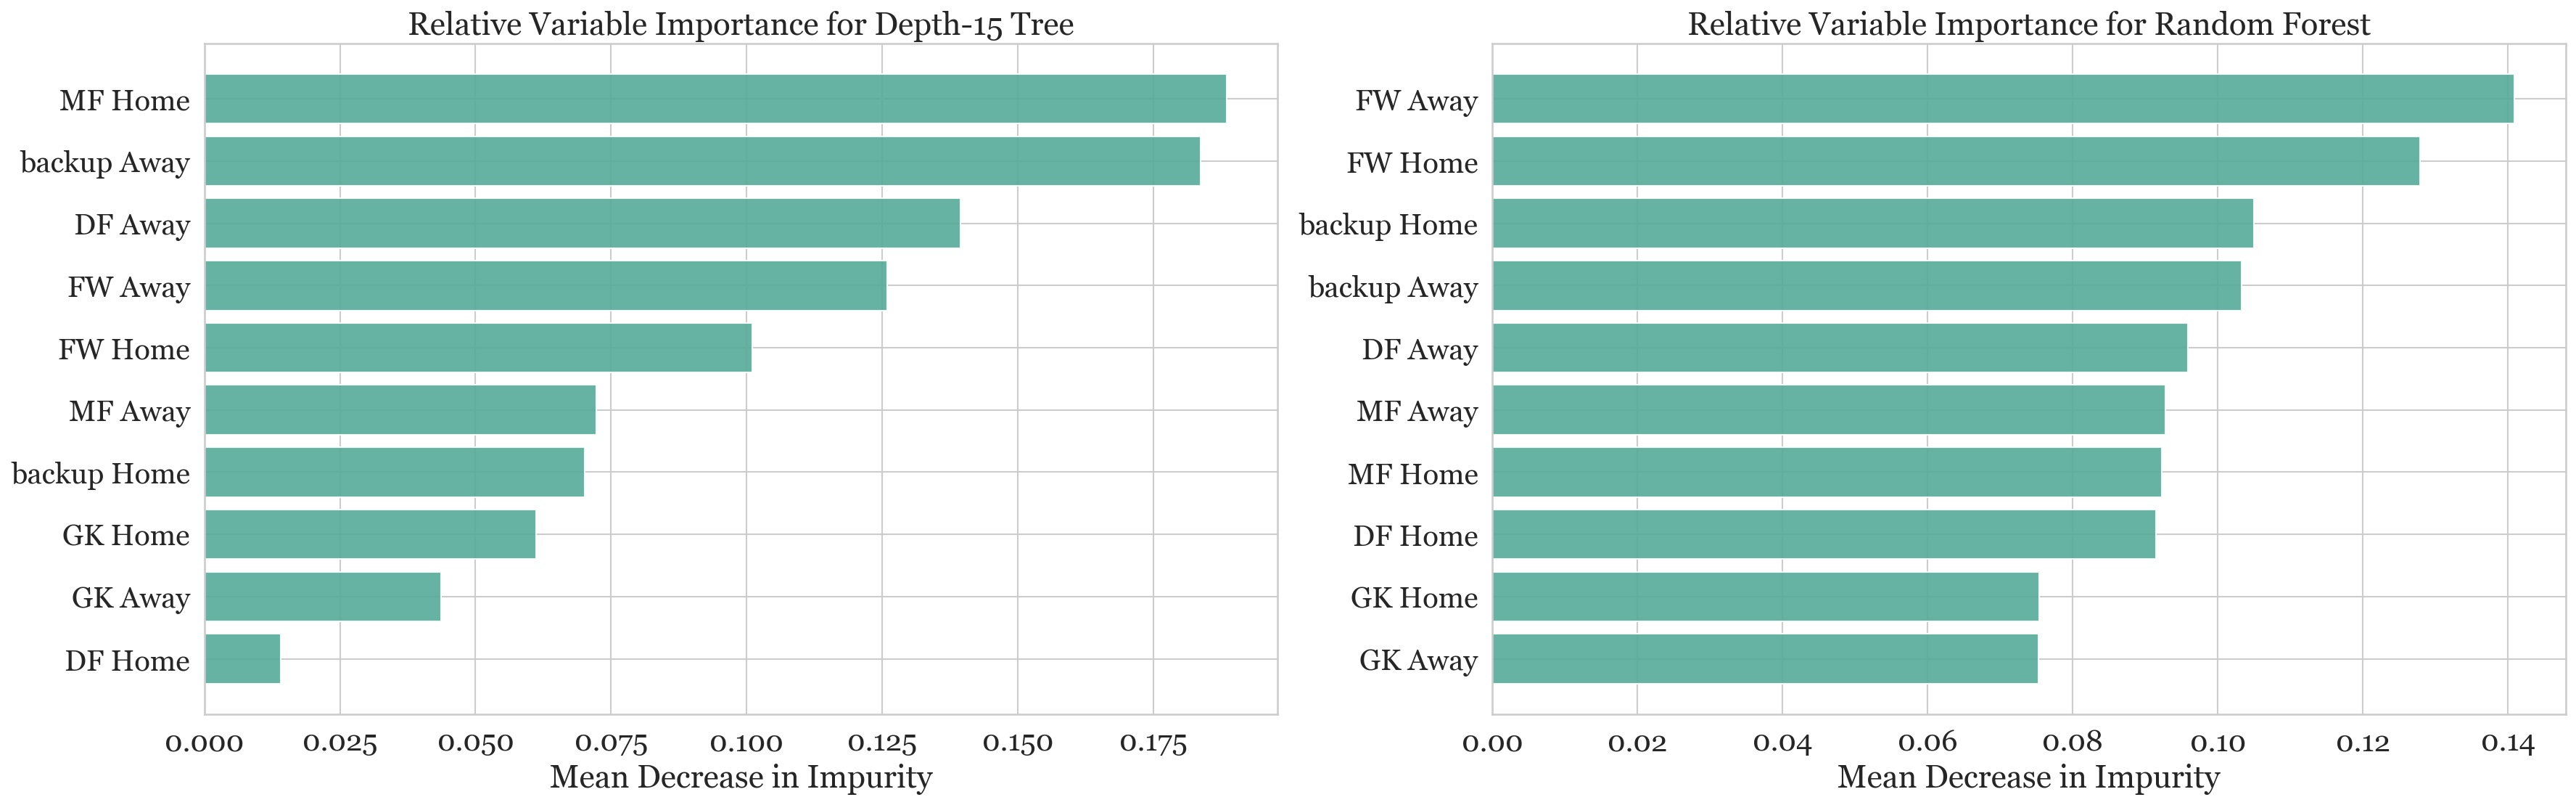

In [140]:
sns.set_theme(style='whitegrid', font='georgia', palette="dark:#5A9_r", font_scale = 1.75)
fig, axs = plt.subplots(1,2, figsize=(28,8))
models = {'Depth-15 Tree': dtree, 'Random Forest': rf} 
num_features = 10 
for i, (name, model) in enumerate(models.items()):
    importances = model.feature_importances_
    order = np.argsort(importances)[-num_features:]
    axs[i].barh(range(num_features), importances[order], tick_label=X_train.columns[order], alpha=0.9);
    axs[i].set_title(f"Relative Variable Importance for {name}")
    axs[i].set_xlabel("Mean Decrease in Impurity")
fig.savefig('test.png')

In [141]:
perm = PermutationImportance(rf, random_state=109, n_iter=10).fit(X_test, y_test)
display(eli5.show_weights(perm, feature_names=X_train.columns.tolist()))

Weight,Feature
0.0712 ± 0.0324,FW Home
0.0500 ± 0.0595,FW Away
0.0385 ± 0.0285,DF Home
0.0365 ± 0.0363,MF Home
0.0327 ± 0.0261,backup Home
0.0231 ± 0.0405,GK Away
0.0115 ± 0.0331,backup Away
0.0067 ± 0.0273,GK Home
0.0000 ± 0.0258,MF Away
-0.0010 ± 0.0303,DF Away


In [142]:
perm = PermutationImportance(dtree, random_state=109, n_iter=10).fit(X_test, y_test)
display(eli5.show_weights(perm, feature_names=X_train.columns.tolist()))

Weight,Feature
0.1308 ± 0.0710,MF Home
0.0981 ± 0.0806,FW Away
0.0385 ± 0.0614,DF Away
0.0365 ± 0.0168,GK Away
0.0260 ± 0.0322,MF Away
0.0163 ± 0.0404,FW Home
0.0154 ± 0.0231,DF Home
0.0077 ± 0.0428,backup Away
-0.0125 ± 0.0150,backup Home
-0.0346 ± 0.0377,GK Home
